## Part 1: Network Training

### Step0: Import Package & Hyperparameter Configuration

In [31]:
%reset -f

import os
import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [32]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 3000
    BATCH_SIZE = 128
    LEARNING_RATE = 0.002  #論文提供
    LR_SCHEDULER_GAMMA = 0.99  #論文提供
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 500
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [33]:
material = "Material B"

# 定義保存模型的路徑
model_save_dir = "./Model/"
os.makedirs(model_save_dir, exist_ok=True)  # 如果路徑不存在，創建路徑

# 定義模型保存檔名
model_save_path = os.path.join(model_save_dir, f"{material}.pt")

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step1: Data processing and data loader generate 

In [34]:
# %% Preprocess data into a data loader
def get_dataloader(data_B, data_F, data_T, data_H, data_Pcv, norm, n_init=16):
    """ #*(Date:250105)
    Process data and return DataLoader for training, validation, and testing.

    Parameters
    ----------
    data_B : np.array
        Magnetic flux density data.
    data_F : np.array
        Frequency data.
    data_T : np.array
        Temperature data.
    data_H : np.array
        Magnetic field strength data.
    data_Pcv : np.array
        Core loss data.
    norm : list
        Normalization parameters for the features.
    n_init : int
        Number of initial data points for magnetization.

    Returns
    -------
    train_loader, valid_loader, test_loader : DataLoader
        Dataloaders for training, validation, and testing sets.
    """

    # Data pre-process
    # 1. Down-sample to 128 points
    seq_length = 128
    cols = range(0, 1024, int(1024 / seq_length))  #range(start, stop, step)
    data_B = data_B[:, cols]
    data_H = data_H[:, cols]  #*  Add H Down-sample to 128 points (Date:241213)

    # 2. Add extra points for initial magnetization calculation
    data_length = seq_length + n_init
    data_B = np.hstack((data_B, data_B[:, :n_init]))
    data_H = np.hstack(
        (data_H, data_H[:, :n_init]))  #*(Date:241216) MMINN output似乎是128點
    #*(Date:250130) 原始MMINN H有包含n_init

    # 3. Format data into tensors  #*(Date:241216) seq_length=128, data_length=144
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # 4. Data Normalization
    in_B = (B - norm[0][0]) / norm[0][1]
    out_H = (H - norm[1][0]) / norm[1][1]
    in_T = (T - norm[3][0]) / norm[3][1]
    in_F = (F - norm[2][0]) / norm[2][1]
    in_Pcv = (Pcv - norm[5][0]) / norm[5][1]

    # 5. Extra features
    dB = torch.diff(B, dim=1)
    dB = torch.cat((dB[:, 0:1], dB), dim=1)
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))

    in_dB = torch.diff(B, dim=1)
    in_dB = torch.cat((in_dB[:, 0:1], in_dB), dim=1)

    in_dB_dt = (dB_dt - norm[4][0]) / norm[4][1]

    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)

    s0 = get_operator_init(in_B[:, 0] - in_dB[:, 0], in_dB, max_B, min_B)

    # 6. Create dataloader to speed up data processing
    full_dataset = torch.utils.data.TensorDataset(
        torch.cat((in_B, in_dB, in_dB_dt), dim=2),  # B 部分（144 點）
        torch.cat((in_F, in_T, in_Pcv), dim=1),  # 輔助變量
        s0,  # 初始狀態
        out_H)

    # Split dataset into train, validation, and test sets (60:20:20)
    train_size = int(0.8 * len(full_dataset))
    valid_size = len(full_dataset) - train_size

    train_dataset, valid_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, valid_size],
        generator=torch.Generator().manual_seed(Config.SEED))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0,
                                               collate_fn=filter_input)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0,
                                               collate_fn=filter_input)

    return train_loader, valid_loader


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=5,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, s0, target_H = zip(*batch)

    # 如果 inputs 是 tuple，先堆疊成張量
    inputs = torch.stack(inputs)  # B 的所有輸入部分（144 點）

    # 保留 in_B, in_dB, in_dB_dt 作為模型輸入
    inputs = inputs[:, :, :3]

    # 保留 features（包括 in_F 和 in_T）
    features = torch.stack(features)[:, :2]

    # 保留目標值 H
    target_H = torch.stack(target_H)[:, -128:, :]  # 只取最後 128 點

    s0 = torch.stack(s0)  # 初始狀態

    return inputs, features, s0, target_H


In [35]:
# %%
# Material normalization data (1.B 2.H 3.F 4.T 5.dB/dt 6.Pv)
normsDict = {
    "Material A": [[-4.02296069e-19, 6.42790612e-02],
                   [1.15118525e-01, 1.22041107e+01],
                   [5.16368866e+00, 2.68540382e-01],
                   [5.52569885e+01, 2.61055470e+01],
                   [2.42224485e-01, 2.37511802e+00],
                   [4.94751596e+00, 8.27844262e-01]],
    "Material B": [[6.75135623e-20, 6.27030179e-02],
                   [3.95575739e-02, 7.62486081e+00],
                   [5.26432657e+00, 2.88519919e-01],
                   [5.80945930e+01, 2.40673885e+01],
                   [2.72521585e-01, 2.46433449e+00],
                   [5.05083704e+00, 7.10303366e-01]],
    "Material C": [[-7.61633305e-19, 7.95720905e-02],
                   [1.11319124e-01, 1.30629103e+01],
                   [5.18559408e+00, 2.68714815e-01],
                   [5.84123573e+01, 2.40717468e+01],
                   [3.26634765e-01, 3.03949690e+00],
                   [4.74633312e+00, 8.05532336e-01]],
    "Material D": [[-3.82835526e-18, 8.10498434e-02],
                   [-1.14488902e-02, 2.83868927e+01],
                   [5.25141287e+00, 2.50821203e-01],
                   [6.72413788e+01, 2.59518223e+01],
                   [3.00584078e-01, 3.24369454e+00],
                   [5.01819372e+00, 8.41059685e-01]],
    "Material E": [[-4.22607249e-18, 1.28762770e-01],
                   [3.88389004e-01, 4.80431443e+01],
                   [5.18909550e+00, 2.77695119e-01],
                   [5.64505730e+01, 2.46127701e+01],
                   [6.35038793e-01, 5.19237566e+00],
                   [5.68955612e+00, 7.26979315e-01]]
}

### Step2: Define Network Structure

In [36]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt)
    - var_size: number of supplenmentary variables (1.F 2.T)        
    - output_size: number of outputs (1.H)
"""


class MMINet(nn.Module):

    def __init__(self,
                 Material,
                 hidden_size=Config.HIDDEN_SIZE,
                 operator_size=Config.OPERATOR_SIZE,
                 input_size=3,
                 var_size=2,
                 output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = normsDict[Material]

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + 2, 1)
        self.rnn2 = EddyCell(4, self.hidden_size, output_size)
        self.dnn2 = nn.Linear(self.hidden_size, 1)

        self.rnn2_hx = None

    def forward(self, x, var, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
          - var(batch,var_size): Supplementary inputs (1.F 2.T)
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # Initialize DNN2 input (1.B 2.dB/dt)
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        H = (output[:, n_init:, :])

        return H


class StopOperatorCell():

    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(5 / operator_size, 5, operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):

    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden

### Step3: Training the Model

In [37]:
# %%
def load_dataset(material, base_path="./Data/Training/"):
    in_file1 = f"{base_path}{material}/B_Field.csv"
    in_file2 = f"{base_path}{material}/Frequency.csv"
    in_file3 = f"{base_path}{material}/Temperature.csv"
    in_file4 = f"{base_path}{material}/H_Field.csv"
    in_file5 = f"{base_path}{material}/Volumetric_Loss.csv"

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N by 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N by 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N by 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N by 1024
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N by 1

    return data_B, data_F, data_T, data_H, data_Pcv


In [38]:
# %%
def train_model(train_loader, valid_loader):

    model = MMINet(Material=material).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

    best_val_loss = float('inf')
    patience_counter = 0

    # 定義保存路徑
    model_save_path = os.path.join("./Model/", f"{material}.pt")

    for epoch in range(Config.NUM_EPOCHS):
        model.train()
        train_loss = 0

        for inputs, features, s0, target_H in train_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, features, s0)  # 模型的輸出
            loss = criterion(outputs, target_H)  # 使用真實的 H(t) 計算損失
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for inputs, features, s0, target_H in valid_loader:
                inputs, features, s0, target_H = inputs.to(
                    device), features.to(device), s0.to(device), target_H.to(
                        device)
                outputs = model(inputs, features, s0)
                loss = criterion(outputs, target_H)
                val_loss += loss.item()

        val_loss /= len(valid_loader)

        print(
            f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}"
        )
        # *======================================================Debug用======================================================
        plot_interval = 50
        if (epoch + 1) % plot_interval == 0:
            outputs = outputs[:3].detach().cpu().numpy()
            targets = target_H[:3].detach().cpu().numpy()

            # 設定圖表
            plt.figure(figsize=(12, 6))

            for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
                plt.plot(outputs[i, :, 0],
                         label=f"Pred: Sample {i+1}",
                         linestyle='--',
                         marker='o')
                plt.plot(targets[i, :, 0],
                         label=f"Target: Sample {i+1}",
                         linestyle='-',
                         marker='x')

            # 添加標題和標籤
            plt.title(f"Compare - Epoch {epoch + 1}", fontsize=16)
            plt.xlabel("Index", fontsize=14)
            plt.ylabel("Value", fontsize=14)
            plt.legend(loc="upper right", fontsize=12)
            plt.grid(alpha=0.5)

            # 顯示圖表
            plt.show()
        # *======================================================Debug用 END ======================================================

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)  # 保存最佳模型
            print(
                f"Saving model at epoch {epoch+1} with validation loss {val_loss:.6f}..."
            )
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

    print(f"Training complete. Best model saved at {model_save_path}.")


In [39]:
# 驗證輸入shape
# net = MMINet(Material=material).to(device)
# for inputs, features, s0 in train_loader:
#     print(f"inputs shape: {inputs.shape}")  # 包括 in_B, in_dB, in_dB_dt
#     print(f"features shape: {features.shape}")  # 包括 in_F, in_T
#     print(f"s0 shape: {s0.shape}")  # 初始化狀態向量
#     break

# 驗證輸出shape
# net = MMINet(Material=material).to(device)
# for inputs, features, s0 in train_loader:
#     # 提取輸入數據
#     inputs = inputs.to(device)  # in_B, in_dB, in_dB_dt
#     features = features.to(device)  # in_F, in_T
#     s0 = s0.to(device)  # 初始狀態向量

#     # 將數據傳入模型
#     outputs = net(inputs, features, s0)

#     # 打印輸出形狀與樣本數據
#     print(f"outputs shape: {outputs.shape}")
#     print(f"outputs data: {outputs[0]}")  # 打印第一個樣本的輸出波形數據
#     break


Epoch 1, Train Loss: 0.670263, Validation Loss: 0.306589
Saving model at epoch 1 with validation loss 0.306589...
Epoch 2, Train Loss: 0.163891, Validation Loss: 0.123217
Saving model at epoch 2 with validation loss 0.123217...
Epoch 3, Train Loss: 0.111693, Validation Loss: 0.097312
Saving model at epoch 3 with validation loss 0.097312...
Epoch 4, Train Loss: 0.089479, Validation Loss: 0.079546
Saving model at epoch 4 with validation loss 0.079546...
Epoch 5, Train Loss: 0.074210, Validation Loss: 0.064924
Saving model at epoch 5 with validation loss 0.064924...
Epoch 6, Train Loss: 0.061134, Validation Loss: 0.054017
Saving model at epoch 6 with validation loss 0.054017...
Epoch 7, Train Loss: 0.052325, Validation Loss: 0.047093
Saving model at epoch 7 with validation loss 0.047093...
Epoch 8, Train Loss: 0.046524, Validation Loss: 0.042775
Saving model at epoch 8 with validation loss 0.042775...
Epoch 9, Train Loss: 0.043006, Validation Loss: 0.040405
Saving model at epoch 9 with va

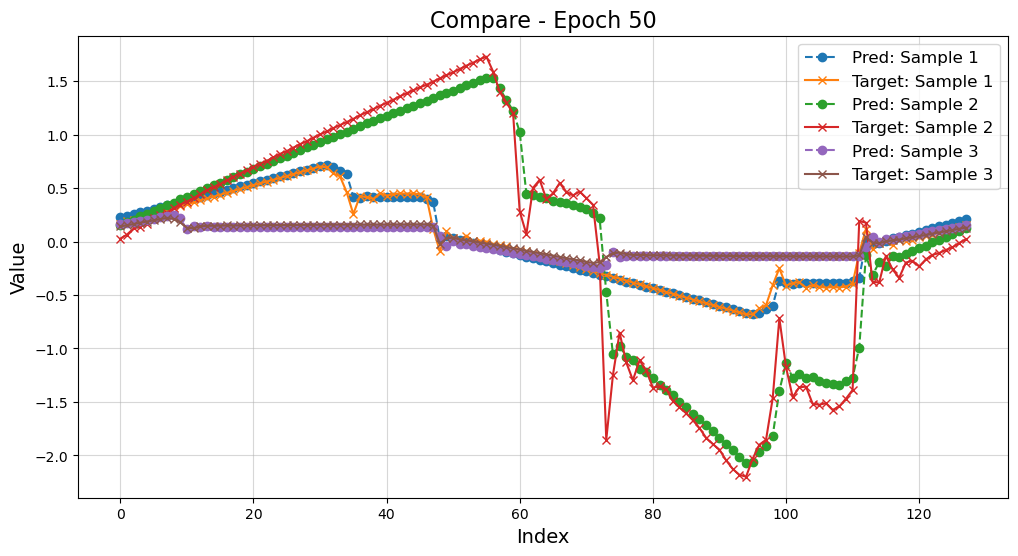

Saving model at epoch 50 with validation loss 0.022247...
Epoch 51, Train Loss: 0.022127, Validation Loss: 0.021863
Saving model at epoch 51 with validation loss 0.021863...
Epoch 52, Train Loss: 0.022118, Validation Loss: 0.021762
Saving model at epoch 52 with validation loss 0.021762...
Epoch 53, Train Loss: 0.021932, Validation Loss: 0.021771
Epoch 54, Train Loss: 0.021632, Validation Loss: 0.021474
Saving model at epoch 54 with validation loss 0.021474...
Epoch 55, Train Loss: 0.021721, Validation Loss: 0.021322
Saving model at epoch 55 with validation loss 0.021322...
Epoch 56, Train Loss: 0.021288, Validation Loss: 0.021192
Saving model at epoch 56 with validation loss 0.021192...
Epoch 57, Train Loss: 0.021175, Validation Loss: 0.021050
Saving model at epoch 57 with validation loss 0.021050...
Epoch 58, Train Loss: 0.021013, Validation Loss: 0.020922
Saving model at epoch 58 with validation loss 0.020922...
Epoch 59, Train Loss: 0.021010, Validation Loss: 0.020805
Saving model a

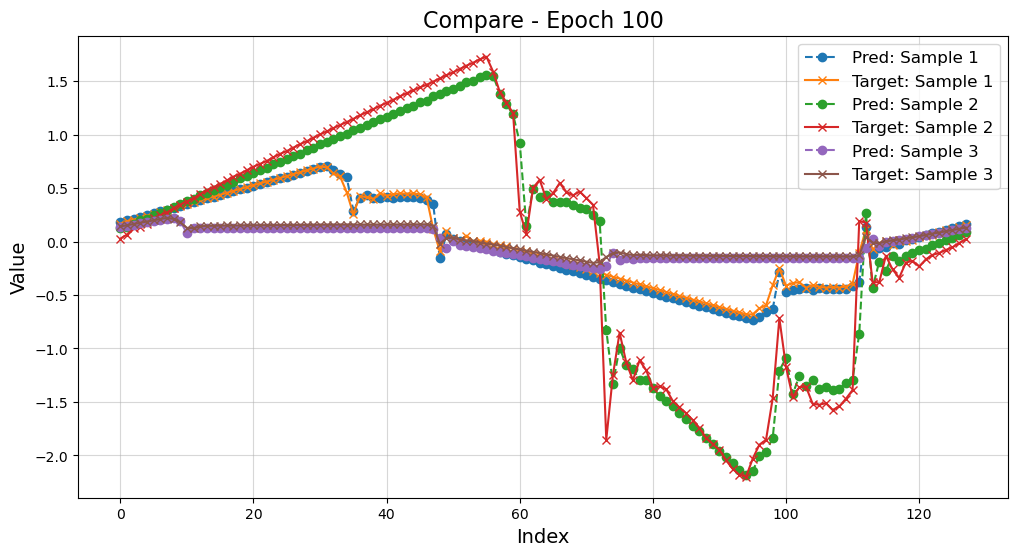

Epoch 101, Train Loss: 0.017599, Validation Loss: 0.018003
Epoch 102, Train Loss: 0.017496, Validation Loss: 0.017368
Saving model at epoch 102 with validation loss 0.017368...
Epoch 103, Train Loss: 0.017339, Validation Loss: 0.017673
Epoch 104, Train Loss: 0.017228, Validation Loss: 0.017166
Saving model at epoch 104 with validation loss 0.017166...
Epoch 105, Train Loss: 0.017332, Validation Loss: 0.017196
Epoch 106, Train Loss: 0.017181, Validation Loss: 0.016990
Saving model at epoch 106 with validation loss 0.016990...
Epoch 107, Train Loss: 0.017058, Validation Loss: 0.017031
Epoch 108, Train Loss: 0.017226, Validation Loss: 0.017230
Epoch 109, Train Loss: 0.017177, Validation Loss: 0.017206
Epoch 110, Train Loss: 0.017075, Validation Loss: 0.016847
Saving model at epoch 110 with validation loss 0.016847...
Epoch 111, Train Loss: 0.016906, Validation Loss: 0.017154
Epoch 112, Train Loss: 0.016729, Validation Loss: 0.016616
Saving model at epoch 112 with validation loss 0.016616.

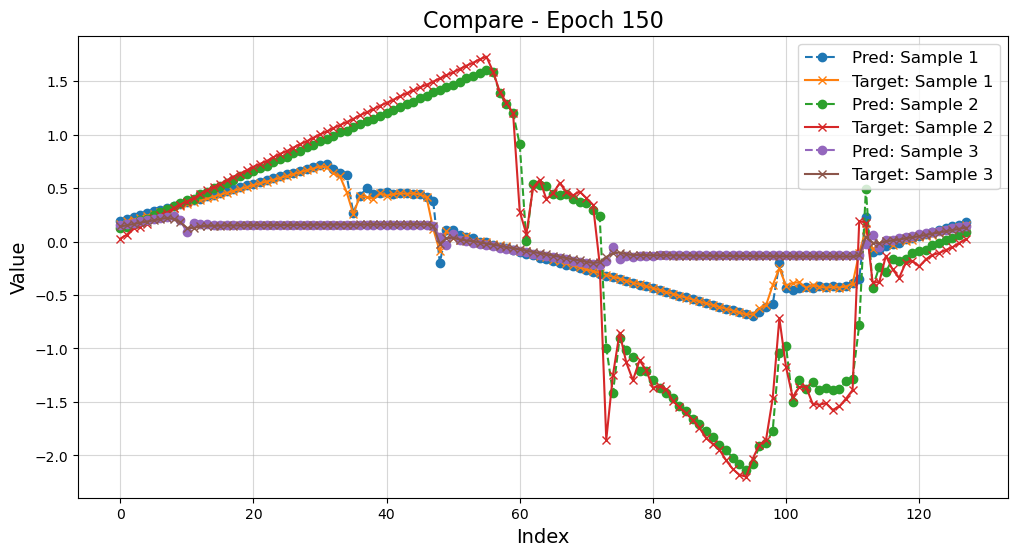

Epoch 151, Train Loss: 0.015146, Validation Loss: 0.014892
Saving model at epoch 151 with validation loss 0.014892...
Epoch 152, Train Loss: 0.014955, Validation Loss: 0.014866
Saving model at epoch 152 with validation loss 0.014866...
Epoch 153, Train Loss: 0.015131, Validation Loss: 0.014903
Epoch 154, Train Loss: 0.015112, Validation Loss: 0.015085
Epoch 155, Train Loss: 0.014943, Validation Loss: 0.014754
Saving model at epoch 155 with validation loss 0.014754...
Epoch 156, Train Loss: 0.014939, Validation Loss: 0.015239
Epoch 157, Train Loss: 0.014822, Validation Loss: 0.014645
Saving model at epoch 157 with validation loss 0.014645...
Epoch 158, Train Loss: 0.014770, Validation Loss: 0.014578
Saving model at epoch 158 with validation loss 0.014578...
Epoch 159, Train Loss: 0.014698, Validation Loss: 0.014760
Epoch 160, Train Loss: 0.014698, Validation Loss: 0.014698
Epoch 161, Train Loss: 0.014764, Validation Loss: 0.014517
Saving model at epoch 161 with validation loss 0.014517.

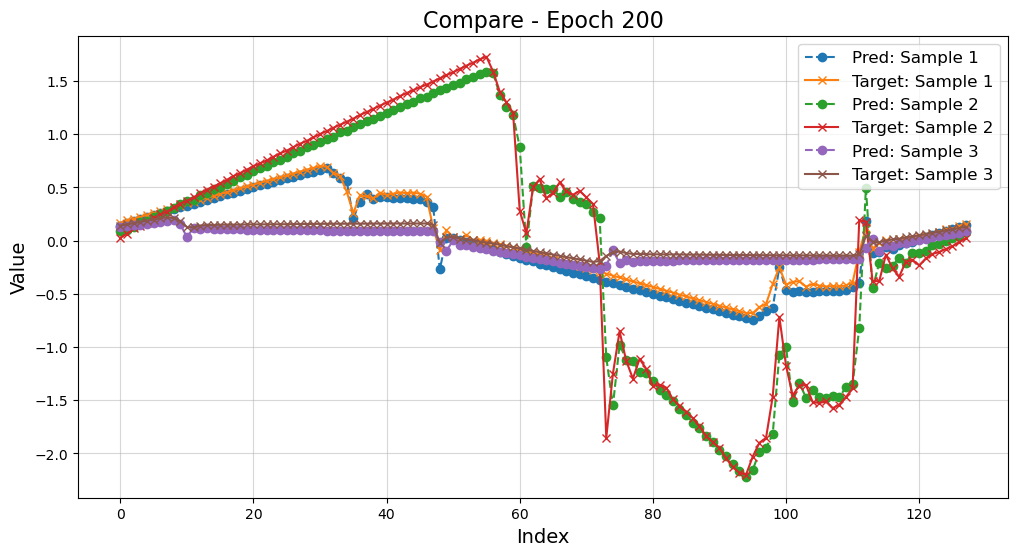

Epoch 201, Train Loss: 0.012154, Validation Loss: 0.012206
Epoch 202, Train Loss: 0.012227, Validation Loss: 0.011885
Saving model at epoch 202 with validation loss 0.011885...
Epoch 203, Train Loss: 0.012037, Validation Loss: 0.011981
Epoch 204, Train Loss: 0.012079, Validation Loss: 0.012219
Epoch 205, Train Loss: 0.012108, Validation Loss: 0.013656
Epoch 206, Train Loss: 0.012461, Validation Loss: 0.011846
Saving model at epoch 206 with validation loss 0.011846...
Epoch 207, Train Loss: 0.011796, Validation Loss: 0.011557
Saving model at epoch 207 with validation loss 0.011557...
Epoch 208, Train Loss: 0.011934, Validation Loss: 0.011780
Epoch 209, Train Loss: 0.011887, Validation Loss: 0.011682
Epoch 210, Train Loss: 0.011832, Validation Loss: 0.011880
Epoch 211, Train Loss: 0.011755, Validation Loss: 0.012218
Epoch 212, Train Loss: 0.011746, Validation Loss: 0.011435
Saving model at epoch 212 with validation loss 0.011435...
Epoch 213, Train Loss: 0.011779, Validation Loss: 0.0121

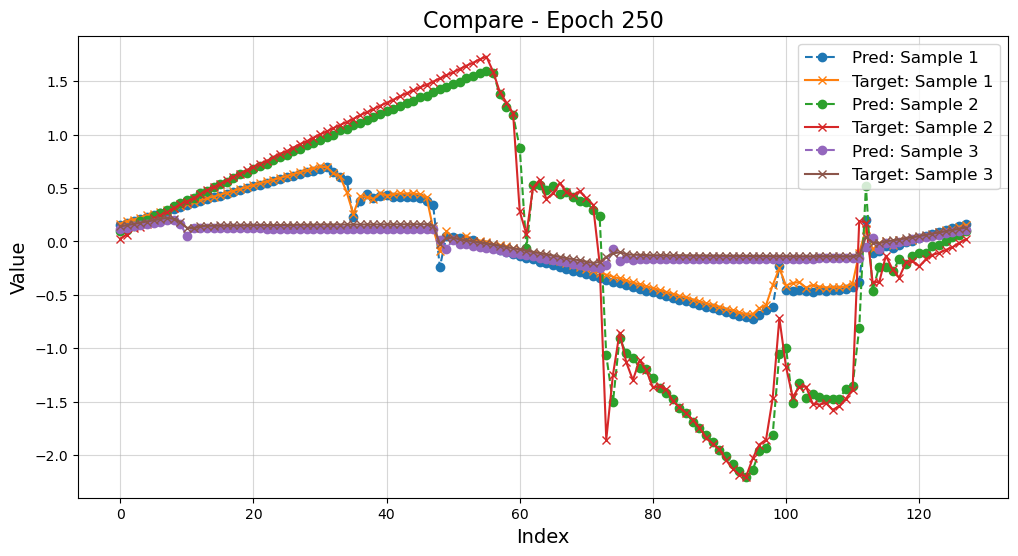

Saving model at epoch 250 with validation loss 0.010632...
Epoch 251, Train Loss: 0.010925, Validation Loss: 0.012330
Epoch 252, Train Loss: 0.011136, Validation Loss: 0.010792
Epoch 253, Train Loss: 0.010963, Validation Loss: 0.012148
Epoch 254, Train Loss: 0.010965, Validation Loss: 0.011375
Epoch 255, Train Loss: 0.011000, Validation Loss: 0.011041
Epoch 256, Train Loss: 0.010792, Validation Loss: 0.010926
Epoch 257, Train Loss: 0.010846, Validation Loss: 0.011402
Epoch 258, Train Loss: 0.011029, Validation Loss: 0.010925
Epoch 259, Train Loss: 0.010900, Validation Loss: 0.010683
Epoch 260, Train Loss: 0.010964, Validation Loss: 0.010757
Epoch 261, Train Loss: 0.010687, Validation Loss: 0.010857
Epoch 262, Train Loss: 0.010794, Validation Loss: 0.011199
Epoch 263, Train Loss: 0.010885, Validation Loss: 0.010609
Saving model at epoch 263 with validation loss 0.010609...
Epoch 264, Train Loss: 0.011331, Validation Loss: 0.011318
Epoch 265, Train Loss: 0.010896, Validation Loss: 0.0107

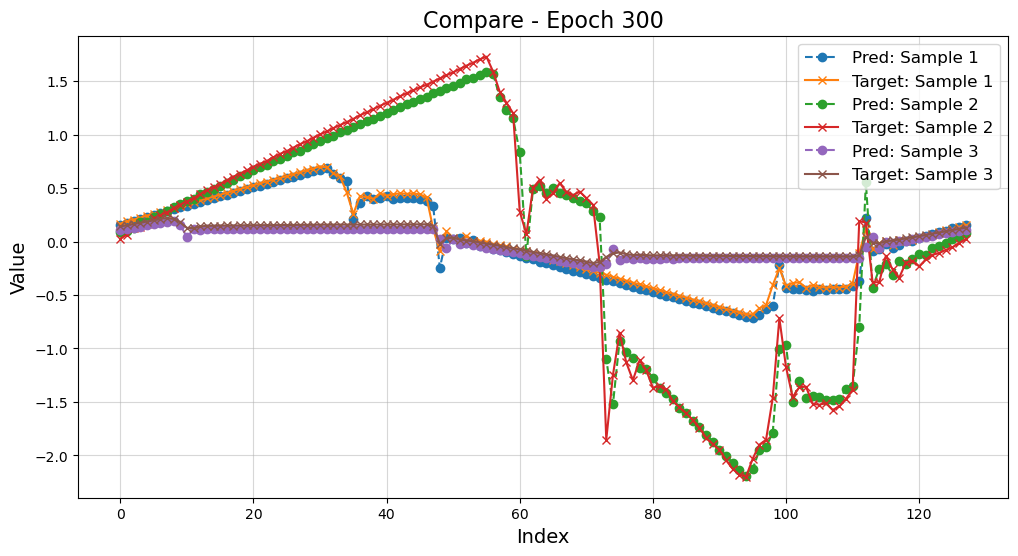

Epoch 301, Train Loss: 0.010464, Validation Loss: 0.010724
Epoch 302, Train Loss: 0.010655, Validation Loss: 0.010590
Epoch 303, Train Loss: 0.010633, Validation Loss: 0.010515
Epoch 304, Train Loss: 0.010460, Validation Loss: 0.010256
Epoch 305, Train Loss: 0.010345, Validation Loss: 0.010335
Epoch 306, Train Loss: 0.010315, Validation Loss: 0.010397
Epoch 307, Train Loss: 0.010490, Validation Loss: 0.010141
Saving model at epoch 307 with validation loss 0.010141...
Epoch 308, Train Loss: 0.010444, Validation Loss: 0.010475
Epoch 309, Train Loss: 0.010417, Validation Loss: 0.010284
Epoch 310, Train Loss: 0.010465, Validation Loss: 0.010345
Epoch 311, Train Loss: 0.010304, Validation Loss: 0.010261
Epoch 312, Train Loss: 0.010369, Validation Loss: 0.010223
Epoch 313, Train Loss: 0.010345, Validation Loss: 0.010387
Epoch 314, Train Loss: 0.010474, Validation Loss: 0.010282
Epoch 315, Train Loss: 0.010585, Validation Loss: 0.010381
Epoch 316, Train Loss: 0.010383, Validation Loss: 0.0105

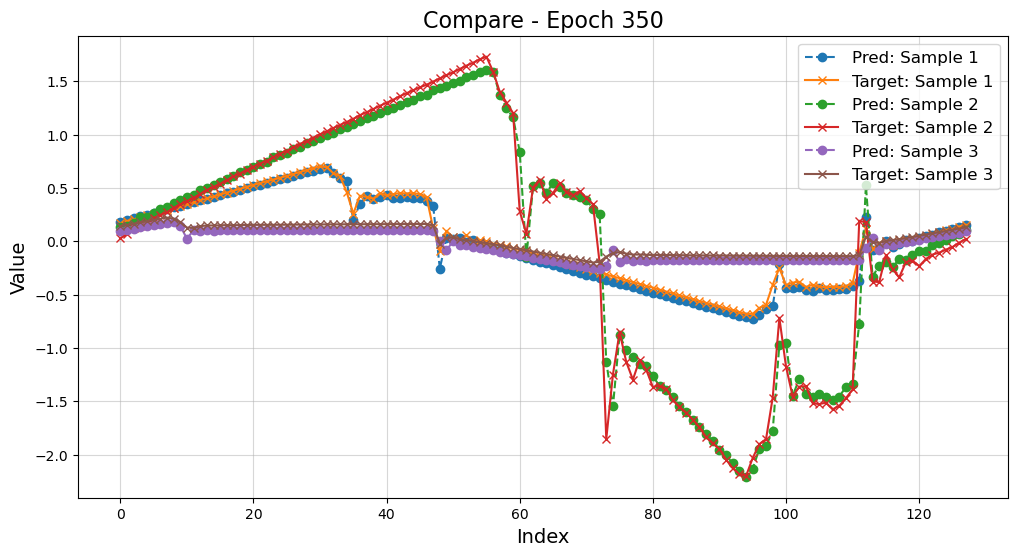

Epoch 351, Train Loss: 0.010126, Validation Loss: 0.009895
Saving model at epoch 351 with validation loss 0.009895...
Epoch 352, Train Loss: 0.010091, Validation Loss: 0.010313
Epoch 353, Train Loss: 0.010122, Validation Loss: 0.009937
Epoch 354, Train Loss: 0.009954, Validation Loss: 0.009910
Epoch 355, Train Loss: 0.010067, Validation Loss: 0.011594
Epoch 356, Train Loss: 0.010452, Validation Loss: 0.009908
Epoch 357, Train Loss: 0.010163, Validation Loss: 0.010212
Epoch 358, Train Loss: 0.010176, Validation Loss: 0.010401
Epoch 359, Train Loss: 0.010310, Validation Loss: 0.010018
Epoch 360, Train Loss: 0.009973, Validation Loss: 0.009860
Saving model at epoch 360 with validation loss 0.009860...
Epoch 361, Train Loss: 0.009938, Validation Loss: 0.010576
Epoch 362, Train Loss: 0.010176, Validation Loss: 0.010028
Epoch 363, Train Loss: 0.010190, Validation Loss: 0.009930
Epoch 364, Train Loss: 0.010259, Validation Loss: 0.010439
Epoch 365, Train Loss: 0.010031, Validation Loss: 0.0099

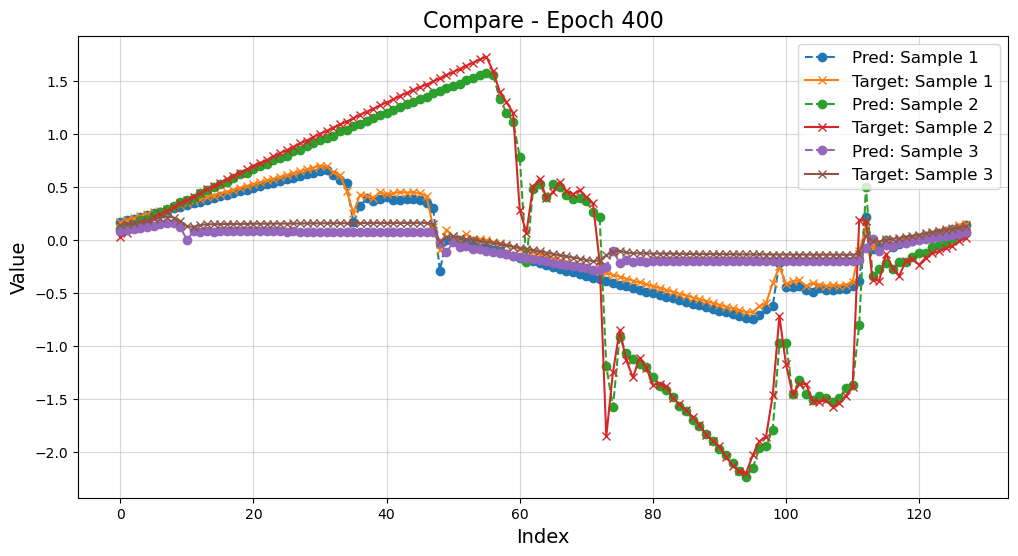

Epoch 401, Train Loss: 0.009816, Validation Loss: 0.009811
Epoch 402, Train Loss: 0.009931, Validation Loss: 0.009665
Epoch 403, Train Loss: 0.009842, Validation Loss: 0.010425
Epoch 404, Train Loss: 0.009787, Validation Loss: 0.009929
Epoch 405, Train Loss: 0.009829, Validation Loss: 0.009610
Saving model at epoch 405 with validation loss 0.009610...
Epoch 406, Train Loss: 0.009769, Validation Loss: 0.009951
Epoch 407, Train Loss: 0.010008, Validation Loss: 0.009746
Epoch 408, Train Loss: 0.009830, Validation Loss: 0.010129
Epoch 409, Train Loss: 0.009817, Validation Loss: 0.009694
Epoch 410, Train Loss: 0.009804, Validation Loss: 0.010265
Epoch 411, Train Loss: 0.009801, Validation Loss: 0.009655
Epoch 412, Train Loss: 0.009800, Validation Loss: 0.010644
Epoch 413, Train Loss: 0.009872, Validation Loss: 0.009903
Epoch 414, Train Loss: 0.009849, Validation Loss: 0.009740
Epoch 415, Train Loss: 0.009898, Validation Loss: 0.009908
Epoch 416, Train Loss: 0.009803, Validation Loss: 0.0100

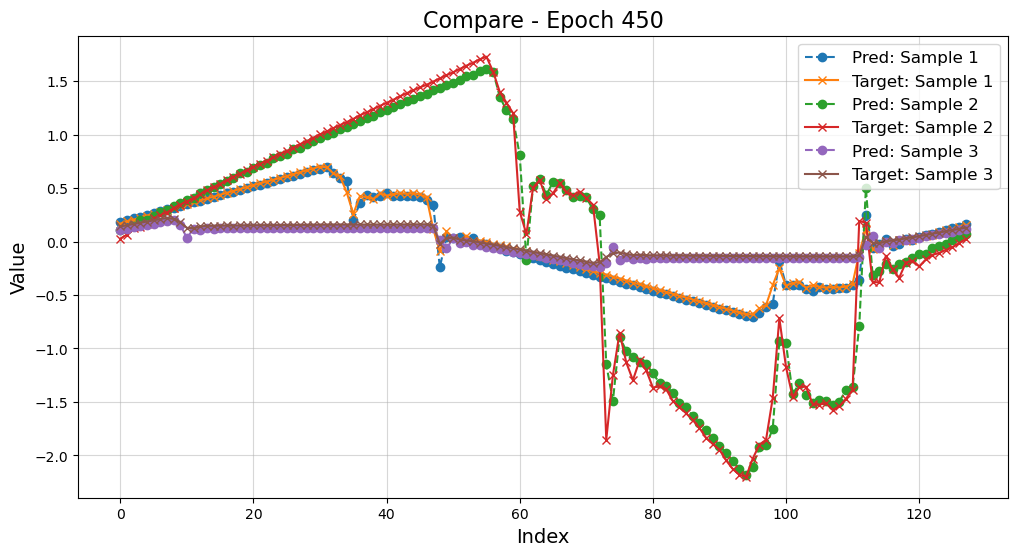

Epoch 451, Train Loss: 0.009533, Validation Loss: 0.009702
Epoch 452, Train Loss: 0.009718, Validation Loss: 0.009683
Epoch 453, Train Loss: 0.009581, Validation Loss: 0.009655
Epoch 454, Train Loss: 0.009709, Validation Loss: 0.009570
Epoch 455, Train Loss: 0.009673, Validation Loss: 0.009742
Epoch 456, Train Loss: 0.009872, Validation Loss: 0.010820
Epoch 457, Train Loss: 0.009782, Validation Loss: 0.009632
Epoch 458, Train Loss: 0.009615, Validation Loss: 0.009635
Epoch 459, Train Loss: 0.009515, Validation Loss: 0.009674
Epoch 460, Train Loss: 0.009617, Validation Loss: 0.009365
Saving model at epoch 460 with validation loss 0.009365...
Epoch 461, Train Loss: 0.009581, Validation Loss: 0.009440
Epoch 462, Train Loss: 0.009647, Validation Loss: 0.009690
Epoch 463, Train Loss: 0.009654, Validation Loss: 0.009321
Saving model at epoch 463 with validation loss 0.009321...
Epoch 464, Train Loss: 0.009511, Validation Loss: 0.010715
Epoch 465, Train Loss: 0.010156, Validation Loss: 0.0096

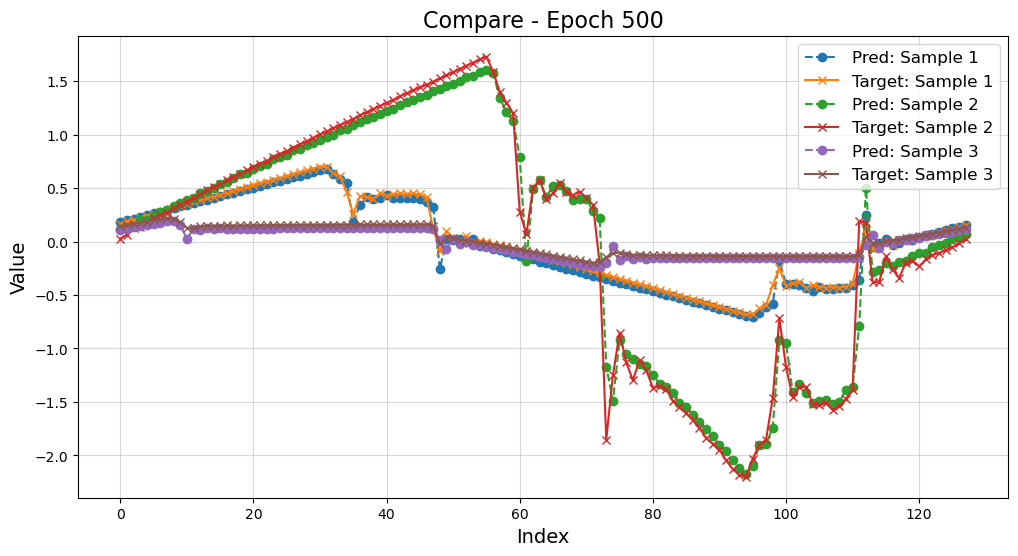

Saving model at epoch 500 with validation loss 0.009256...
Epoch 501, Train Loss: 0.009531, Validation Loss: 0.009663
Epoch 502, Train Loss: 0.009506, Validation Loss: 0.009213
Saving model at epoch 502 with validation loss 0.009213...
Epoch 503, Train Loss: 0.009395, Validation Loss: 0.009205
Saving model at epoch 503 with validation loss 0.009205...
Epoch 504, Train Loss: 0.009588, Validation Loss: 0.009221
Epoch 505, Train Loss: 0.009394, Validation Loss: 0.009475
Epoch 506, Train Loss: 0.009510, Validation Loss: 0.009706
Epoch 507, Train Loss: 0.009440, Validation Loss: 0.009189
Saving model at epoch 507 with validation loss 0.009189...
Epoch 508, Train Loss: 0.009472, Validation Loss: 0.009261
Epoch 509, Train Loss: 0.009345, Validation Loss: 0.009264
Epoch 510, Train Loss: 0.009289, Validation Loss: 0.009200
Epoch 511, Train Loss: 0.009391, Validation Loss: 0.009377
Epoch 512, Train Loss: 0.009552, Validation Loss: 0.009184
Saving model at epoch 512 with validation loss 0.009184.

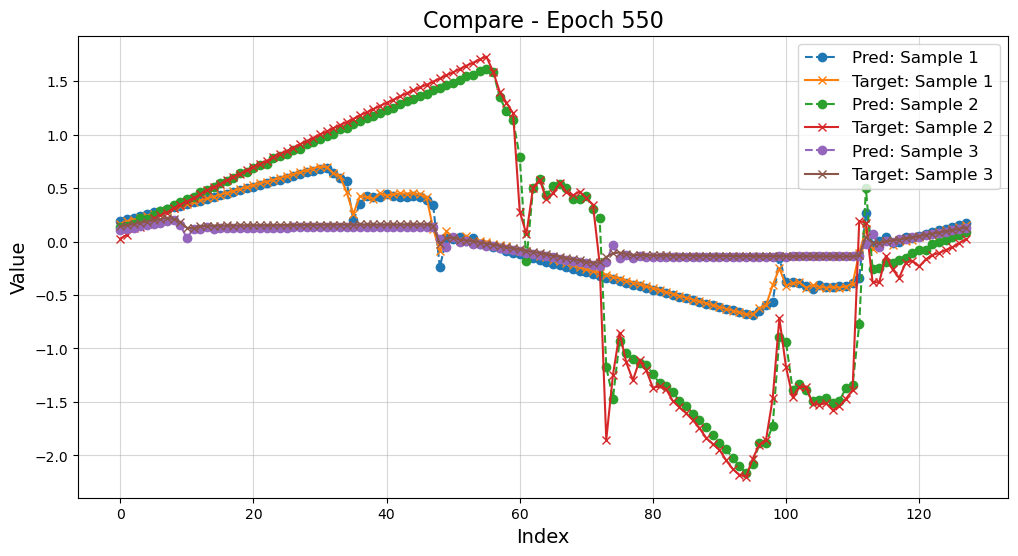

Epoch 551, Train Loss: 0.009128, Validation Loss: 0.009363
Epoch 552, Train Loss: 0.009376, Validation Loss: 0.009215
Epoch 553, Train Loss: 0.009249, Validation Loss: 0.009020
Saving model at epoch 553 with validation loss 0.009020...
Epoch 554, Train Loss: 0.009275, Validation Loss: 0.009100
Epoch 555, Train Loss: 0.009624, Validation Loss: 0.009225
Epoch 556, Train Loss: 0.009298, Validation Loss: 0.009359
Epoch 557, Train Loss: 0.009210, Validation Loss: 0.009146
Epoch 558, Train Loss: 0.009117, Validation Loss: 0.009003
Saving model at epoch 558 with validation loss 0.009003...
Epoch 559, Train Loss: 0.009515, Validation Loss: 0.009063
Epoch 560, Train Loss: 0.009215, Validation Loss: 0.009223
Epoch 561, Train Loss: 0.009306, Validation Loss: 0.009484
Epoch 562, Train Loss: 0.009185, Validation Loss: 0.009054
Epoch 563, Train Loss: 0.009235, Validation Loss: 0.009357
Epoch 564, Train Loss: 0.009330, Validation Loss: 0.009068
Epoch 565, Train Loss: 0.009301, Validation Loss: 0.0095

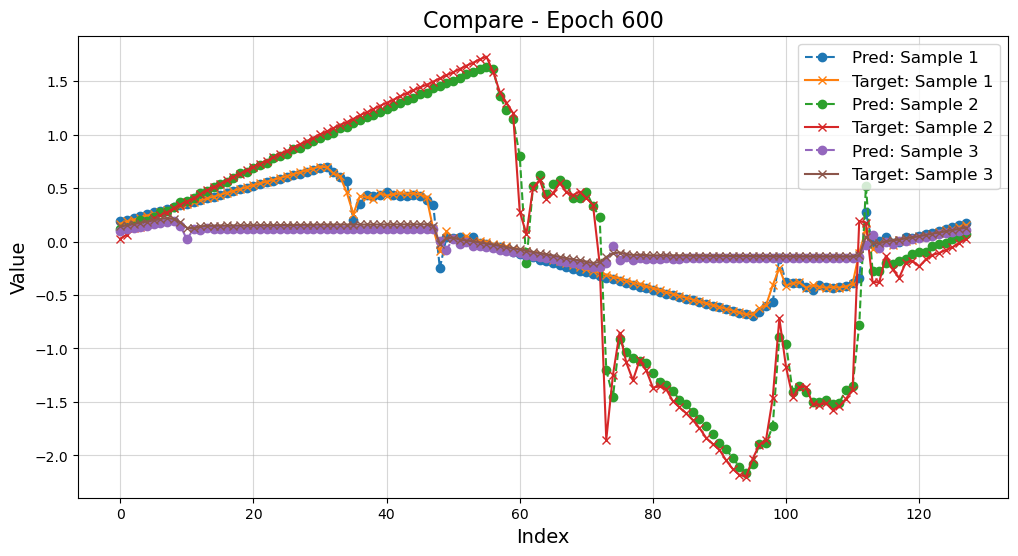

Epoch 601, Train Loss: 0.008981, Validation Loss: 0.008920
Epoch 602, Train Loss: 0.009226, Validation Loss: 0.009331
Epoch 603, Train Loss: 0.009262, Validation Loss: 0.009757
Epoch 604, Train Loss: 0.009077, Validation Loss: 0.008867
Saving model at epoch 604 with validation loss 0.008867...
Epoch 605, Train Loss: 0.009116, Validation Loss: 0.008996
Epoch 606, Train Loss: 0.009195, Validation Loss: 0.008898
Epoch 607, Train Loss: 0.009036, Validation Loss: 0.008915
Epoch 608, Train Loss: 0.009246, Validation Loss: 0.008949
Epoch 609, Train Loss: 0.009072, Validation Loss: 0.009170
Epoch 610, Train Loss: 0.008966, Validation Loss: 0.008856
Saving model at epoch 610 with validation loss 0.008856...
Epoch 611, Train Loss: 0.009082, Validation Loss: 0.009374
Epoch 612, Train Loss: 0.009087, Validation Loss: 0.008802
Saving model at epoch 612 with validation loss 0.008802...
Epoch 613, Train Loss: 0.009145, Validation Loss: 0.008799
Saving model at epoch 613 with validation loss 0.008799.

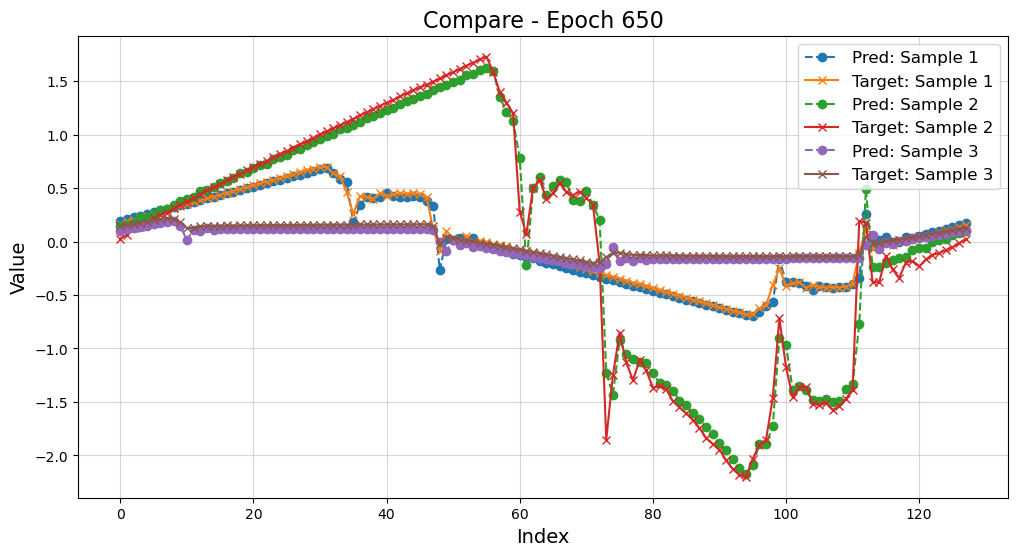

Epoch 651, Train Loss: 0.008858, Validation Loss: 0.008846
Epoch 652, Train Loss: 0.008967, Validation Loss: 0.008816
Epoch 653, Train Loss: 0.009138, Validation Loss: 0.010308
Epoch 654, Train Loss: 0.009092, Validation Loss: 0.008894
Epoch 655, Train Loss: 0.008926, Validation Loss: 0.008812
Epoch 656, Train Loss: 0.008988, Validation Loss: 0.008796
Epoch 657, Train Loss: 0.008944, Validation Loss: 0.010056
Epoch 658, Train Loss: 0.009380, Validation Loss: 0.008820
Epoch 659, Train Loss: 0.008997, Validation Loss: 0.008759
Epoch 660, Train Loss: 0.008840, Validation Loss: 0.008795
Epoch 661, Train Loss: 0.008942, Validation Loss: 0.008946
Epoch 662, Train Loss: 0.008963, Validation Loss: 0.008667
Saving model at epoch 662 with validation loss 0.008667...
Epoch 663, Train Loss: 0.008965, Validation Loss: 0.008839
Epoch 664, Train Loss: 0.008875, Validation Loss: 0.008673
Epoch 665, Train Loss: 0.008859, Validation Loss: 0.008713
Epoch 666, Train Loss: 0.008848, Validation Loss: 0.0087

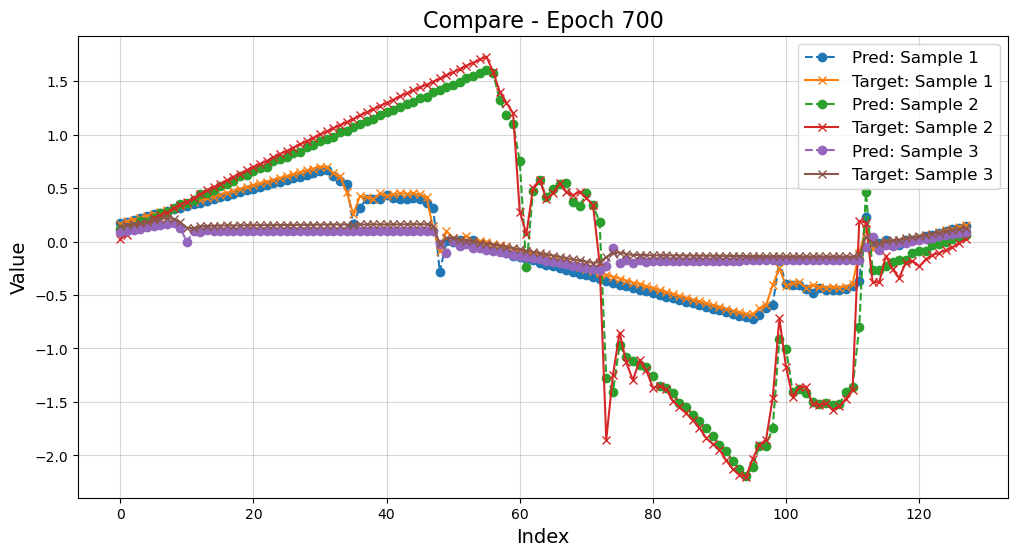

Epoch 701, Train Loss: 0.008977, Validation Loss: 0.010442
Epoch 702, Train Loss: 0.008955, Validation Loss: 0.008679
Epoch 703, Train Loss: 0.008781, Validation Loss: 0.009127
Epoch 704, Train Loss: 0.008847, Validation Loss: 0.008678
Epoch 705, Train Loss: 0.008670, Validation Loss: 0.008608
Saving model at epoch 705 with validation loss 0.008608...
Epoch 706, Train Loss: 0.008620, Validation Loss: 0.008645
Epoch 707, Train Loss: 0.008957, Validation Loss: 0.009081
Epoch 708, Train Loss: 0.008704, Validation Loss: 0.008809
Epoch 709, Train Loss: 0.008687, Validation Loss: 0.008546
Saving model at epoch 709 with validation loss 0.008546...
Epoch 710, Train Loss: 0.008717, Validation Loss: 0.008666
Epoch 711, Train Loss: 0.008757, Validation Loss: 0.008627
Epoch 712, Train Loss: 0.008750, Validation Loss: 0.008993
Epoch 713, Train Loss: 0.008724, Validation Loss: 0.008741
Epoch 714, Train Loss: 0.008775, Validation Loss: 0.008923
Epoch 715, Train Loss: 0.008725, Validation Loss: 0.0088

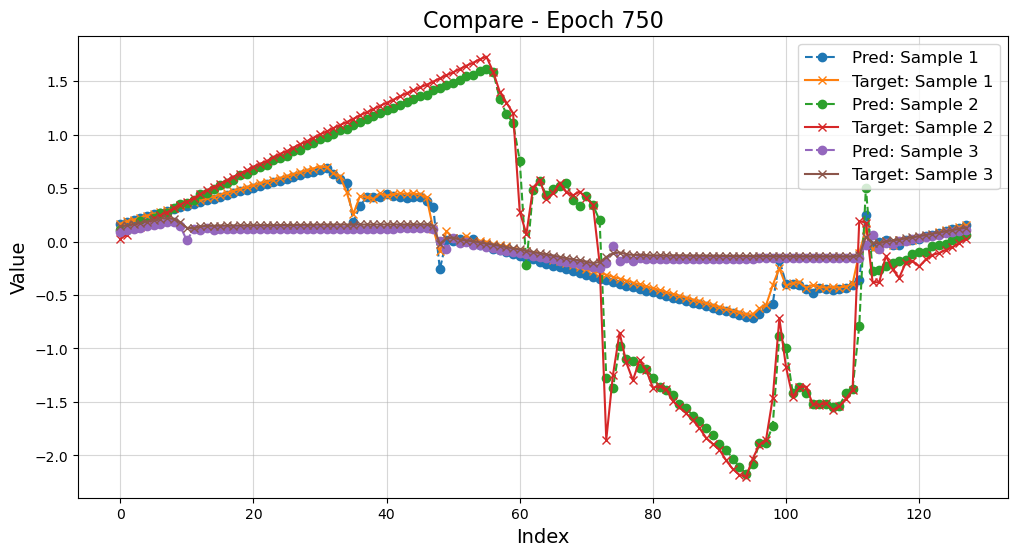

Epoch 751, Train Loss: 0.008608, Validation Loss: 0.008578
Epoch 752, Train Loss: 0.008807, Validation Loss: 0.008531
Epoch 753, Train Loss: 0.008783, Validation Loss: 0.008574
Epoch 754, Train Loss: 0.008574, Validation Loss: 0.008431
Saving model at epoch 754 with validation loss 0.008431...
Epoch 755, Train Loss: 0.008619, Validation Loss: 0.008470
Epoch 756, Train Loss: 0.008608, Validation Loss: 0.008419
Saving model at epoch 756 with validation loss 0.008419...
Epoch 757, Train Loss: 0.008728, Validation Loss: 0.008981
Epoch 758, Train Loss: 0.008711, Validation Loss: 0.008704
Epoch 759, Train Loss: 0.008552, Validation Loss: 0.008629
Epoch 760, Train Loss: 0.008841, Validation Loss: 0.008588
Epoch 761, Train Loss: 0.008738, Validation Loss: 0.009186
Epoch 762, Train Loss: 0.008950, Validation Loss: 0.009141
Epoch 763, Train Loss: 0.008609, Validation Loss: 0.008438
Epoch 764, Train Loss: 0.008492, Validation Loss: 0.008736
Epoch 765, Train Loss: 0.008715, Validation Loss: 0.0087

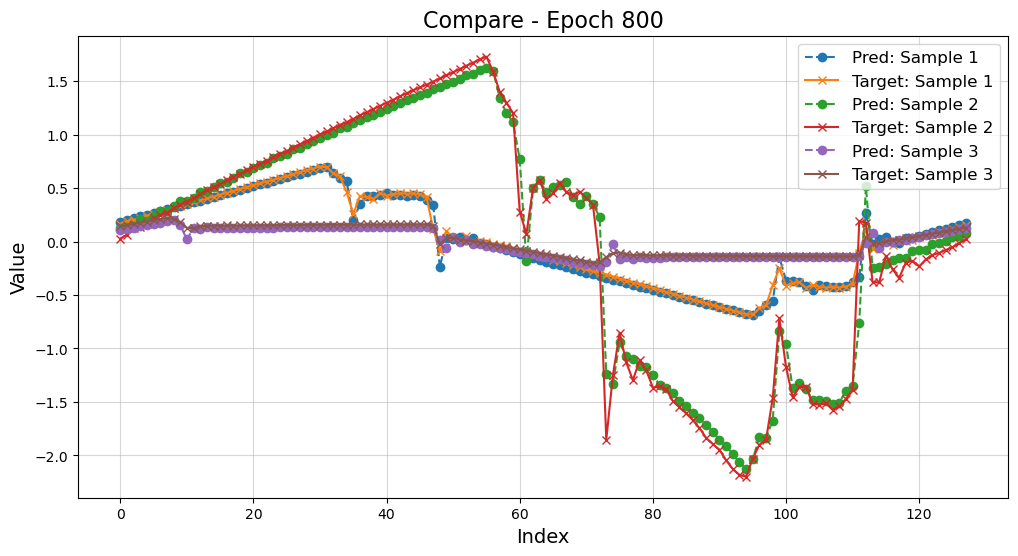

Epoch 801, Train Loss: 0.008384, Validation Loss: 0.008375
Epoch 802, Train Loss: 0.008455, Validation Loss: 0.008279
Saving model at epoch 802 with validation loss 0.008279...
Epoch 803, Train Loss: 0.008752, Validation Loss: 0.008534
Epoch 804, Train Loss: 0.008455, Validation Loss: 0.008575
Epoch 805, Train Loss: 0.008628, Validation Loss: 0.008731
Epoch 806, Train Loss: 0.008699, Validation Loss: 0.008382
Epoch 807, Train Loss: 0.008515, Validation Loss: 0.008965
Epoch 808, Train Loss: 0.008705, Validation Loss: 0.008807
Epoch 809, Train Loss: 0.008489, Validation Loss: 0.008749
Epoch 810, Train Loss: 0.008573, Validation Loss: 0.008287
Epoch 811, Train Loss: 0.008572, Validation Loss: 0.008279
Saving model at epoch 811 with validation loss 0.008279...
Epoch 812, Train Loss: 0.008461, Validation Loss: 0.008427
Epoch 813, Train Loss: 0.008434, Validation Loss: 0.008525
Epoch 814, Train Loss: 0.008405, Validation Loss: 0.008435
Epoch 815, Train Loss: 0.008492, Validation Loss: 0.0083

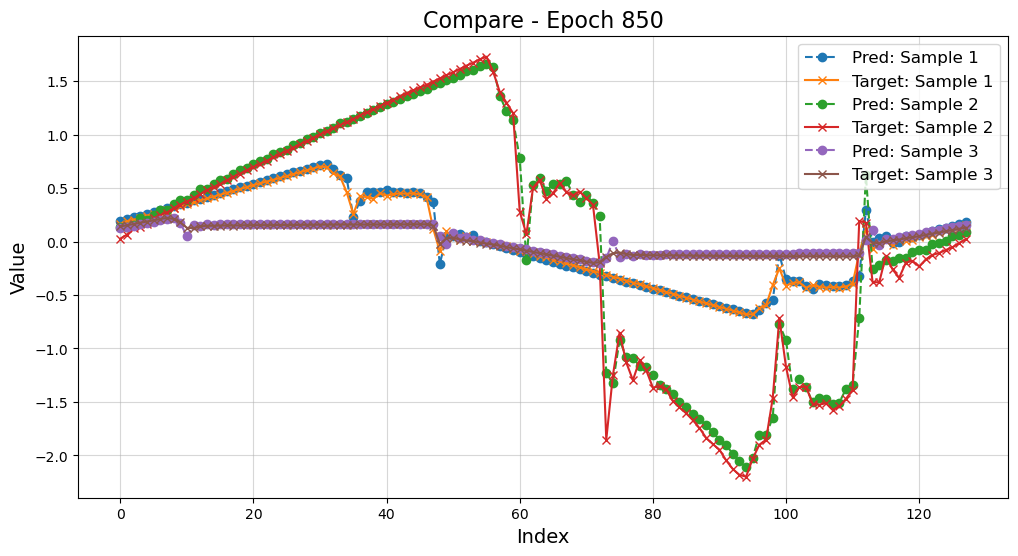

Epoch 851, Train Loss: 0.008512, Validation Loss: 0.009033
Epoch 852, Train Loss: 0.008476, Validation Loss: 0.008267
Epoch 853, Train Loss: 0.008311, Validation Loss: 0.008221
Saving model at epoch 853 with validation loss 0.008221...
Epoch 854, Train Loss: 0.008569, Validation Loss: 0.008391
Epoch 855, Train Loss: 0.008354, Validation Loss: 0.008274
Epoch 856, Train Loss: 0.008460, Validation Loss: 0.008187
Saving model at epoch 856 with validation loss 0.008187...
Epoch 857, Train Loss: 0.008380, Validation Loss: 0.008220
Epoch 858, Train Loss: 0.008272, Validation Loss: 0.008523
Epoch 859, Train Loss: 0.008299, Validation Loss: 0.008628
Epoch 860, Train Loss: 0.008288, Validation Loss: 0.008198
Epoch 861, Train Loss: 0.008278, Validation Loss: 0.008921
Epoch 862, Train Loss: 0.008681, Validation Loss: 0.008251
Epoch 863, Train Loss: 0.008313, Validation Loss: 0.008154
Saving model at epoch 863 with validation loss 0.008154...
Epoch 864, Train Loss: 0.008372, Validation Loss: 0.0082

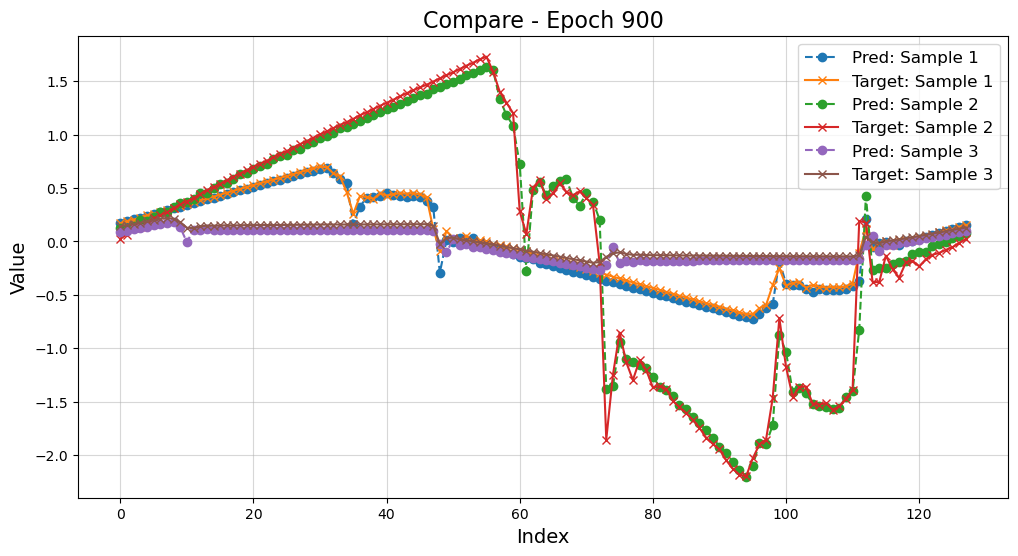

Epoch 901, Train Loss: 0.008453, Validation Loss: 0.008297
Epoch 902, Train Loss: 0.008168, Validation Loss: 0.008244
Epoch 903, Train Loss: 0.008348, Validation Loss: 0.008346
Epoch 904, Train Loss: 0.008359, Validation Loss: 0.008616
Epoch 905, Train Loss: 0.008325, Validation Loss: 0.008162
Epoch 906, Train Loss: 0.008214, Validation Loss: 0.008431
Epoch 907, Train Loss: 0.008223, Validation Loss: 0.008348
Epoch 908, Train Loss: 0.008125, Validation Loss: 0.008051
Saving model at epoch 908 with validation loss 0.008051...
Epoch 909, Train Loss: 0.008254, Validation Loss: 0.008764
Epoch 910, Train Loss: 0.008503, Validation Loss: 0.008721
Epoch 911, Train Loss: 0.008334, Validation Loss: 0.008076
Epoch 912, Train Loss: 0.008302, Validation Loss: 0.011002
Epoch 913, Train Loss: 0.008612, Validation Loss: 0.008299
Epoch 914, Train Loss: 0.008108, Validation Loss: 0.008141
Epoch 915, Train Loss: 0.008200, Validation Loss: 0.008270
Epoch 916, Train Loss: 0.008292, Validation Loss: 0.0081

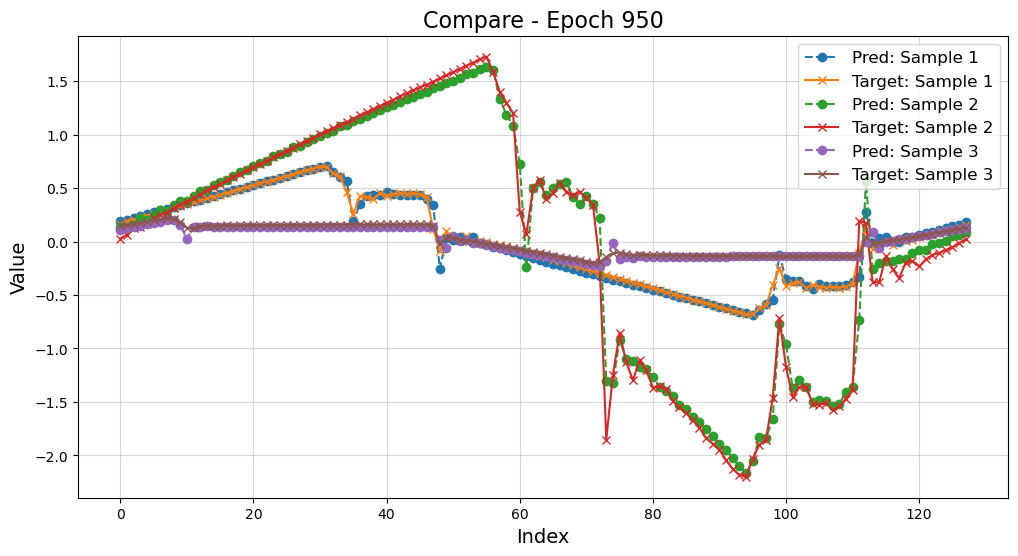

Epoch 951, Train Loss: 0.008177, Validation Loss: 0.008081
Epoch 952, Train Loss: 0.008174, Validation Loss: 0.009054
Epoch 953, Train Loss: 0.008098, Validation Loss: 0.007939
Saving model at epoch 953 with validation loss 0.007939...
Epoch 954, Train Loss: 0.008045, Validation Loss: 0.008414
Epoch 955, Train Loss: 0.008027, Validation Loss: 0.008098
Epoch 956, Train Loss: 0.007986, Validation Loss: 0.008054
Epoch 957, Train Loss: 0.008146, Validation Loss: 0.008261
Epoch 958, Train Loss: 0.008118, Validation Loss: 0.008525
Epoch 959, Train Loss: 0.008150, Validation Loss: 0.008319
Epoch 960, Train Loss: 0.008010, Validation Loss: 0.008028
Epoch 961, Train Loss: 0.008286, Validation Loss: 0.007979
Epoch 962, Train Loss: 0.008055, Validation Loss: 0.007988
Epoch 963, Train Loss: 0.008286, Validation Loss: 0.008442
Epoch 964, Train Loss: 0.008061, Validation Loss: 0.008126
Epoch 965, Train Loss: 0.008101, Validation Loss: 0.008035
Epoch 966, Train Loss: 0.008044, Validation Loss: 0.0085

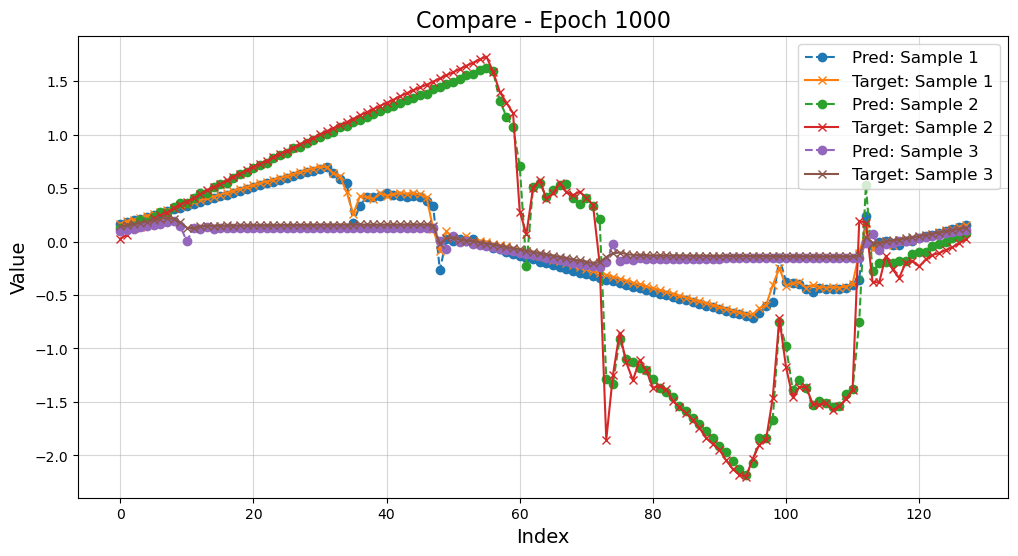

Epoch 1001, Train Loss: 0.007957, Validation Loss: 0.007926
Epoch 1002, Train Loss: 0.007887, Validation Loss: 0.008005
Epoch 1003, Train Loss: 0.007929, Validation Loss: 0.007997
Epoch 1004, Train Loss: 0.007861, Validation Loss: 0.007846
Epoch 1005, Train Loss: 0.008011, Validation Loss: 0.008090
Epoch 1006, Train Loss: 0.008076, Validation Loss: 0.008130
Epoch 1007, Train Loss: 0.007942, Validation Loss: 0.007891
Epoch 1008, Train Loss: 0.008010, Validation Loss: 0.008033
Epoch 1009, Train Loss: 0.007944, Validation Loss: 0.008943
Epoch 1010, Train Loss: 0.008022, Validation Loss: 0.007853
Epoch 1011, Train Loss: 0.008075, Validation Loss: 0.008037
Epoch 1012, Train Loss: 0.007999, Validation Loss: 0.007931
Epoch 1013, Train Loss: 0.007885, Validation Loss: 0.007935
Epoch 1014, Train Loss: 0.007986, Validation Loss: 0.007921
Epoch 1015, Train Loss: 0.007952, Validation Loss: 0.008028
Epoch 1016, Train Loss: 0.007945, Validation Loss: 0.007840
Epoch 1017, Train Loss: 0.007941, Valida

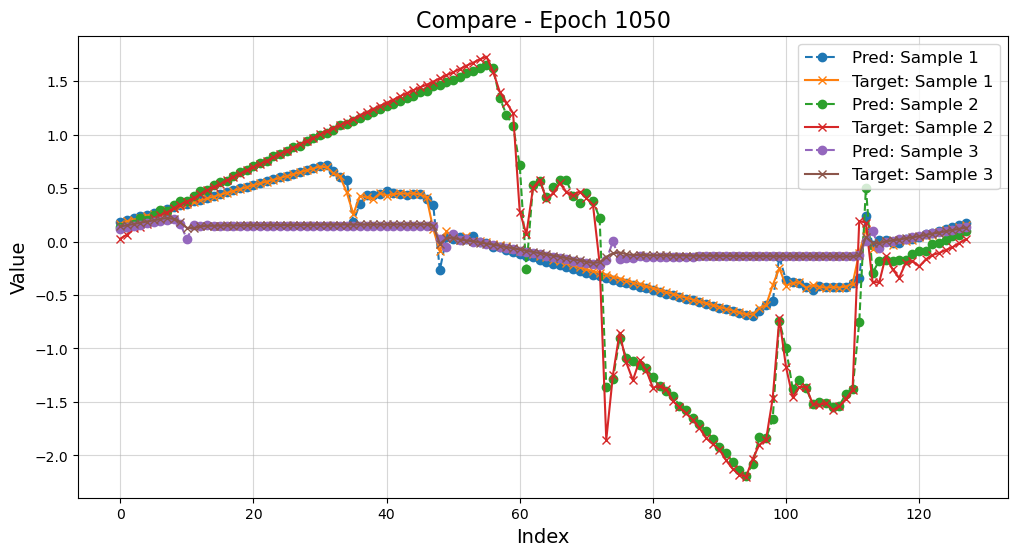

Epoch 1051, Train Loss: 0.007744, Validation Loss: 0.007816
Epoch 1052, Train Loss: 0.007910, Validation Loss: 0.008222
Epoch 1053, Train Loss: 0.007908, Validation Loss: 0.008056
Epoch 1054, Train Loss: 0.007992, Validation Loss: 0.007998
Epoch 1055, Train Loss: 0.007987, Validation Loss: 0.008289
Epoch 1056, Train Loss: 0.007834, Validation Loss: 0.008119
Epoch 1057, Train Loss: 0.008189, Validation Loss: 0.007875
Epoch 1058, Train Loss: 0.007786, Validation Loss: 0.007888
Epoch 1059, Train Loss: 0.007718, Validation Loss: 0.007814
Epoch 1060, Train Loss: 0.007800, Validation Loss: 0.007955
Epoch 1061, Train Loss: 0.007811, Validation Loss: 0.008424
Epoch 1062, Train Loss: 0.007860, Validation Loss: 0.008062
Epoch 1063, Train Loss: 0.007727, Validation Loss: 0.007728
Saving model at epoch 1063 with validation loss 0.007728...
Epoch 1064, Train Loss: 0.007642, Validation Loss: 0.008425
Epoch 1065, Train Loss: 0.007801, Validation Loss: 0.007710
Saving model at epoch 1065 with validati

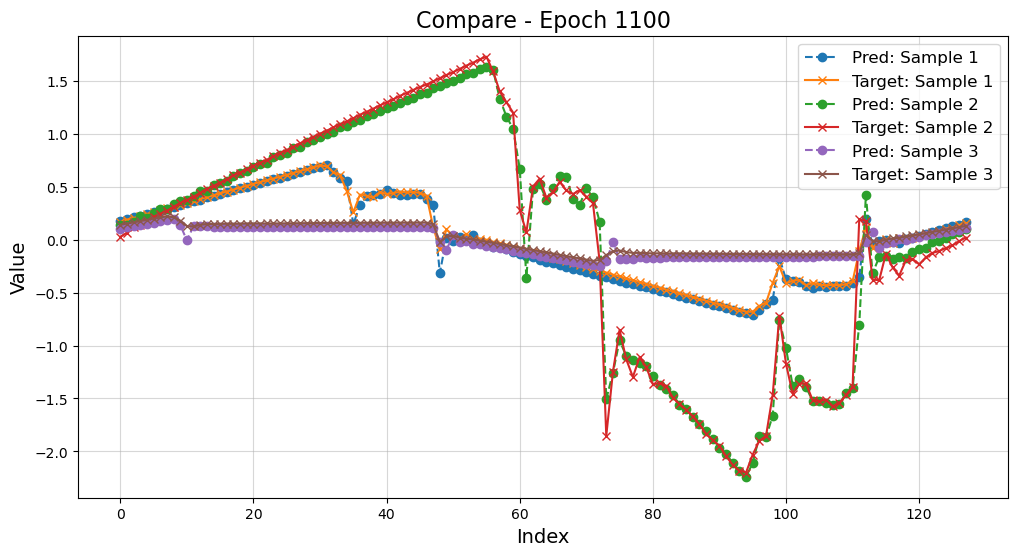

Epoch 1101, Train Loss: 0.007765, Validation Loss: 0.007618
Epoch 1102, Train Loss: 0.007670, Validation Loss: 0.008490
Epoch 1103, Train Loss: 0.007707, Validation Loss: 0.007676
Epoch 1104, Train Loss: 0.007554, Validation Loss: 0.007571
Saving model at epoch 1104 with validation loss 0.007571...
Epoch 1105, Train Loss: 0.007748, Validation Loss: 0.008701
Epoch 1106, Train Loss: 0.008021, Validation Loss: 0.007664
Epoch 1107, Train Loss: 0.007685, Validation Loss: 0.007620
Epoch 1108, Train Loss: 0.007593, Validation Loss: 0.008019
Epoch 1109, Train Loss: 0.007694, Validation Loss: 0.007720
Epoch 1110, Train Loss: 0.007607, Validation Loss: 0.007654
Epoch 1111, Train Loss: 0.007569, Validation Loss: 0.007539
Saving model at epoch 1111 with validation loss 0.007539...
Epoch 1112, Train Loss: 0.007767, Validation Loss: 0.007643
Epoch 1113, Train Loss: 0.007642, Validation Loss: 0.008000
Epoch 1114, Train Loss: 0.007785, Validation Loss: 0.007809
Epoch 1115, Train Loss: 0.007566, Valida

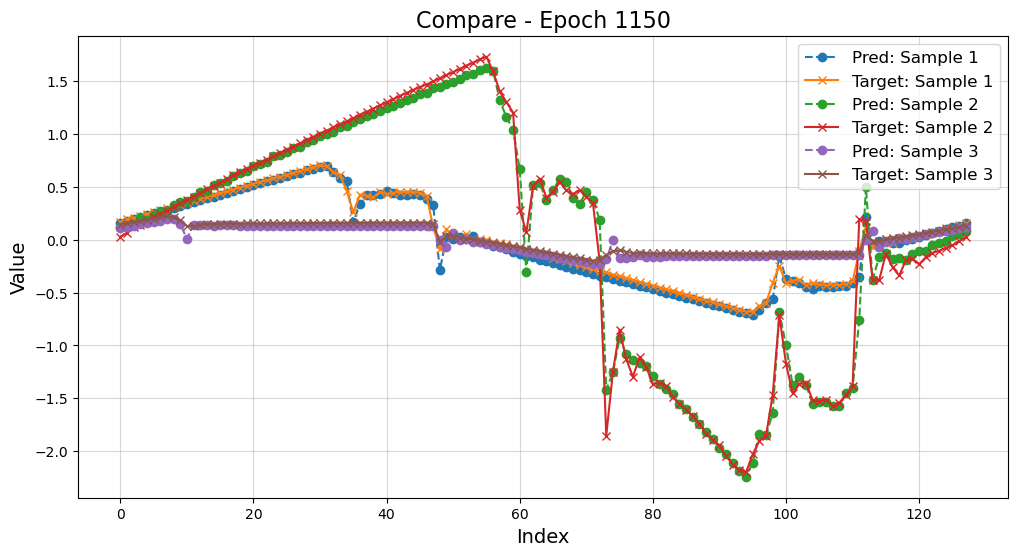

Saving model at epoch 1150 with validation loss 0.007457...
Epoch 1151, Train Loss: 0.007536, Validation Loss: 0.007868
Epoch 1152, Train Loss: 0.007558, Validation Loss: 0.007485
Epoch 1153, Train Loss: 0.007639, Validation Loss: 0.007759
Epoch 1154, Train Loss: 0.007541, Validation Loss: 0.007578
Epoch 1155, Train Loss: 0.007566, Validation Loss: 0.007562
Epoch 1156, Train Loss: 0.007489, Validation Loss: 0.007593
Epoch 1157, Train Loss: 0.007487, Validation Loss: 0.007501
Epoch 1158, Train Loss: 0.007454, Validation Loss: 0.008035
Epoch 1159, Train Loss: 0.007548, Validation Loss: 0.007534
Epoch 1160, Train Loss: 0.007646, Validation Loss: 0.007696
Epoch 1161, Train Loss: 0.007584, Validation Loss: 0.007959
Epoch 1162, Train Loss: 0.007470, Validation Loss: 0.007600
Epoch 1163, Train Loss: 0.007632, Validation Loss: 0.007508
Epoch 1164, Train Loss: 0.007583, Validation Loss: 0.007716
Epoch 1165, Train Loss: 0.007575, Validation Loss: 0.007551
Epoch 1166, Train Loss: 0.007576, Valida

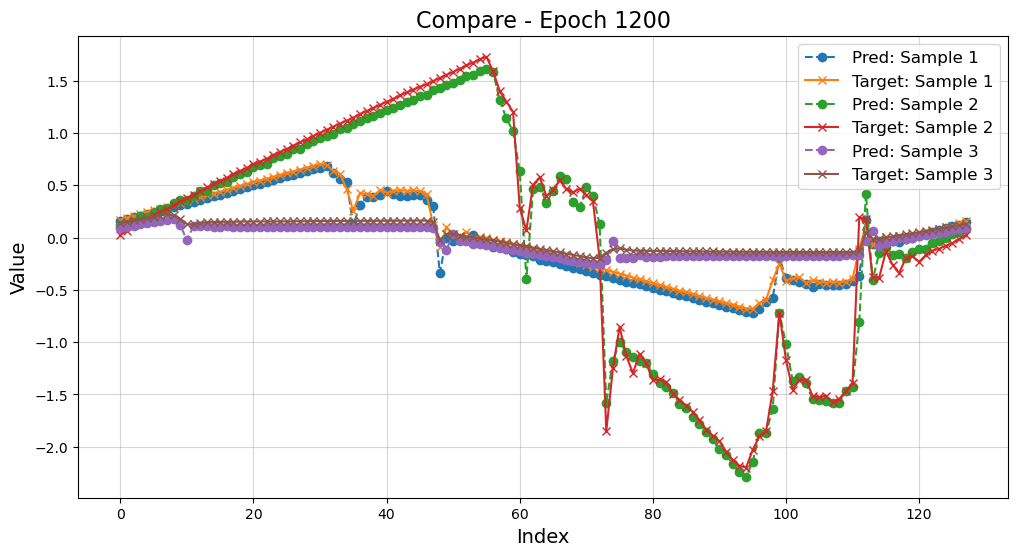

Epoch 1201, Train Loss: 0.007376, Validation Loss: 0.007461
Epoch 1202, Train Loss: 0.007343, Validation Loss: 0.007468
Epoch 1203, Train Loss: 0.007363, Validation Loss: 0.007336
Epoch 1204, Train Loss: 0.007427, Validation Loss: 0.008166
Epoch 1205, Train Loss: 0.007678, Validation Loss: 0.007480
Epoch 1206, Train Loss: 0.007342, Validation Loss: 0.007311
Epoch 1207, Train Loss: 0.007474, Validation Loss: 0.007452
Epoch 1208, Train Loss: 0.007363, Validation Loss: 0.007703
Epoch 1209, Train Loss: 0.007340, Validation Loss: 0.007453
Epoch 1210, Train Loss: 0.007520, Validation Loss: 0.007871
Epoch 1211, Train Loss: 0.007535, Validation Loss: 0.007341
Epoch 1212, Train Loss: 0.007531, Validation Loss: 0.008833
Epoch 1213, Train Loss: 0.007789, Validation Loss: 0.007466
Epoch 1214, Train Loss: 0.007408, Validation Loss: 0.007489
Epoch 1215, Train Loss: 0.007371, Validation Loss: 0.007638
Epoch 1216, Train Loss: 0.007460, Validation Loss: 0.007474
Epoch 1217, Train Loss: 0.007345, Valida

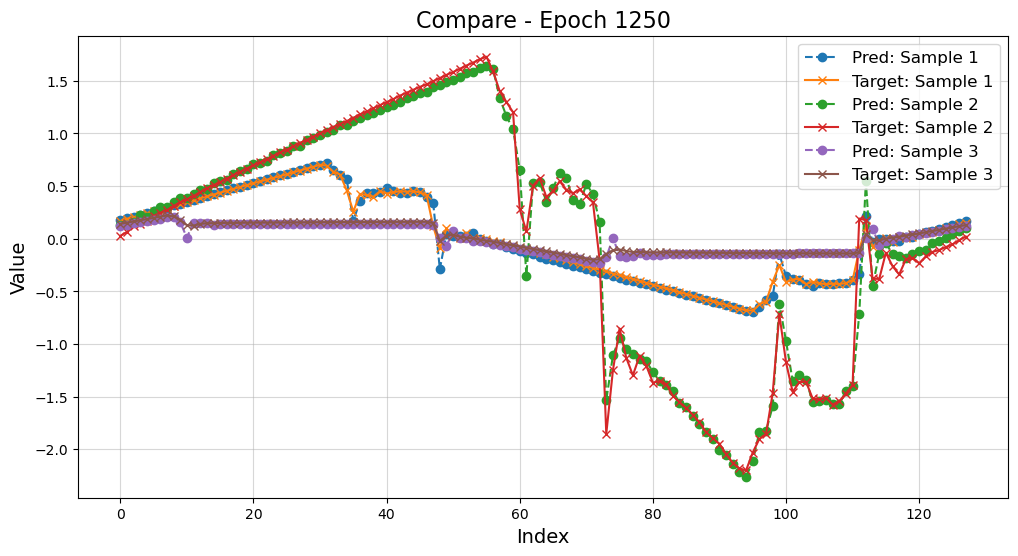

Epoch 1251, Train Loss: 0.007273, Validation Loss: 0.009055
Epoch 1252, Train Loss: 0.007589, Validation Loss: 0.007253
Epoch 1253, Train Loss: 0.007654, Validation Loss: 0.008140
Epoch 1254, Train Loss: 0.007538, Validation Loss: 0.007706
Epoch 1255, Train Loss: 0.007481, Validation Loss: 0.007490
Epoch 1256, Train Loss: 0.007311, Validation Loss: 0.007287
Epoch 1257, Train Loss: 0.007184, Validation Loss: 0.007373
Epoch 1258, Train Loss: 0.007612, Validation Loss: 0.007333
Epoch 1259, Train Loss: 0.007506, Validation Loss: 0.007425
Epoch 1260, Train Loss: 0.007354, Validation Loss: 0.007379
Epoch 1261, Train Loss: 0.007358, Validation Loss: 0.007328
Epoch 1262, Train Loss: 0.007323, Validation Loss: 0.007617
Epoch 1263, Train Loss: 0.007275, Validation Loss: 0.009126
Epoch 1264, Train Loss: 0.007480, Validation Loss: 0.007476
Epoch 1265, Train Loss: 0.007309, Validation Loss: 0.007364
Epoch 1266, Train Loss: 0.007296, Validation Loss: 0.008150
Epoch 1267, Train Loss: 0.007295, Valida

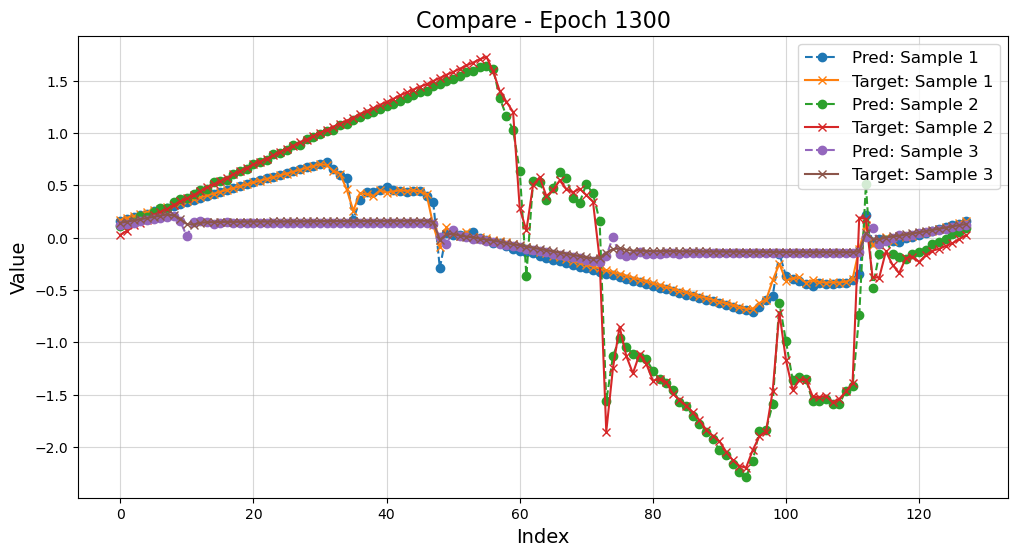

Saving model at epoch 1300 with validation loss 0.007140...
Epoch 1301, Train Loss: 0.007224, Validation Loss: 0.007433
Epoch 1302, Train Loss: 0.007125, Validation Loss: 0.007291
Epoch 1303, Train Loss: 0.007190, Validation Loss: 0.007157
Epoch 1304, Train Loss: 0.007376, Validation Loss: 0.007186
Epoch 1305, Train Loss: 0.007290, Validation Loss: 0.007383
Epoch 1306, Train Loss: 0.007199, Validation Loss: 0.007707
Epoch 1307, Train Loss: 0.007251, Validation Loss: 0.007600
Epoch 1308, Train Loss: 0.007615, Validation Loss: 0.007211
Epoch 1309, Train Loss: 0.007112, Validation Loss: 0.007625
Epoch 1310, Train Loss: 0.007332, Validation Loss: 0.007126
Saving model at epoch 1310 with validation loss 0.007126...
Epoch 1311, Train Loss: 0.007130, Validation Loss: 0.007348
Epoch 1312, Train Loss: 0.007233, Validation Loss: 0.007394
Epoch 1313, Train Loss: 0.007178, Validation Loss: 0.007135
Epoch 1314, Train Loss: 0.007089, Validation Loss: 0.007218
Epoch 1315, Train Loss: 0.007086, Valida

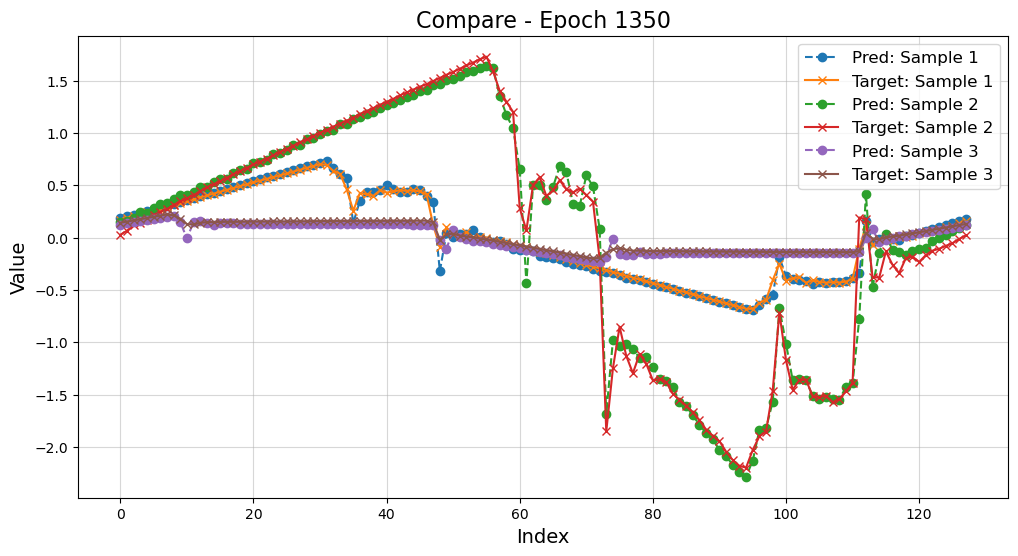

Epoch 1351, Train Loss: 0.007110, Validation Loss: 0.007184
Epoch 1352, Train Loss: 0.007084, Validation Loss: 0.007280
Epoch 1353, Train Loss: 0.007130, Validation Loss: 0.007118
Epoch 1354, Train Loss: 0.007172, Validation Loss: 0.007329
Epoch 1355, Train Loss: 0.007363, Validation Loss: 0.007353
Epoch 1356, Train Loss: 0.007450, Validation Loss: 0.007266
Epoch 1357, Train Loss: 0.007197, Validation Loss: 0.007313
Epoch 1358, Train Loss: 0.007298, Validation Loss: 0.007642
Epoch 1359, Train Loss: 0.007168, Validation Loss: 0.007472
Epoch 1360, Train Loss: 0.007106, Validation Loss: 0.008357
Epoch 1361, Train Loss: 0.007209, Validation Loss: 0.006980
Saving model at epoch 1361 with validation loss 0.006980...
Epoch 1362, Train Loss: 0.007053, Validation Loss: 0.007438
Epoch 1363, Train Loss: 0.007025, Validation Loss: 0.007042
Epoch 1364, Train Loss: 0.007146, Validation Loss: 0.007519
Epoch 1365, Train Loss: 0.007189, Validation Loss: 0.007076
Epoch 1366, Train Loss: 0.007281, Valida

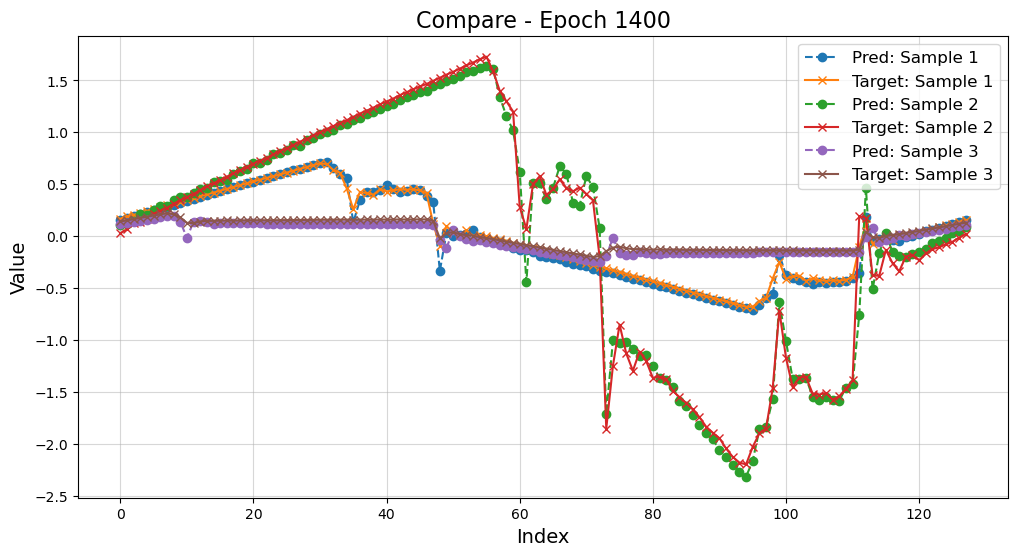

Epoch 1401, Train Loss: 0.007181, Validation Loss: 0.007570
Epoch 1402, Train Loss: 0.007054, Validation Loss: 0.007139
Epoch 1403, Train Loss: 0.007002, Validation Loss: 0.007499
Epoch 1404, Train Loss: 0.007172, Validation Loss: 0.007027
Epoch 1405, Train Loss: 0.006925, Validation Loss: 0.007151
Epoch 1406, Train Loss: 0.006911, Validation Loss: 0.007340
Epoch 1407, Train Loss: 0.006933, Validation Loss: 0.007053
Epoch 1408, Train Loss: 0.007075, Validation Loss: 0.007005
Epoch 1409, Train Loss: 0.007152, Validation Loss: 0.007032
Epoch 1410, Train Loss: 0.007354, Validation Loss: 0.008619
Epoch 1411, Train Loss: 0.007264, Validation Loss: 0.006981
Epoch 1412, Train Loss: 0.006967, Validation Loss: 0.006981
Epoch 1413, Train Loss: 0.006916, Validation Loss: 0.006956
Epoch 1414, Train Loss: 0.007052, Validation Loss: 0.007035
Epoch 1415, Train Loss: 0.006910, Validation Loss: 0.007206
Epoch 1416, Train Loss: 0.006991, Validation Loss: 0.007095
Epoch 1417, Train Loss: 0.006921, Valida

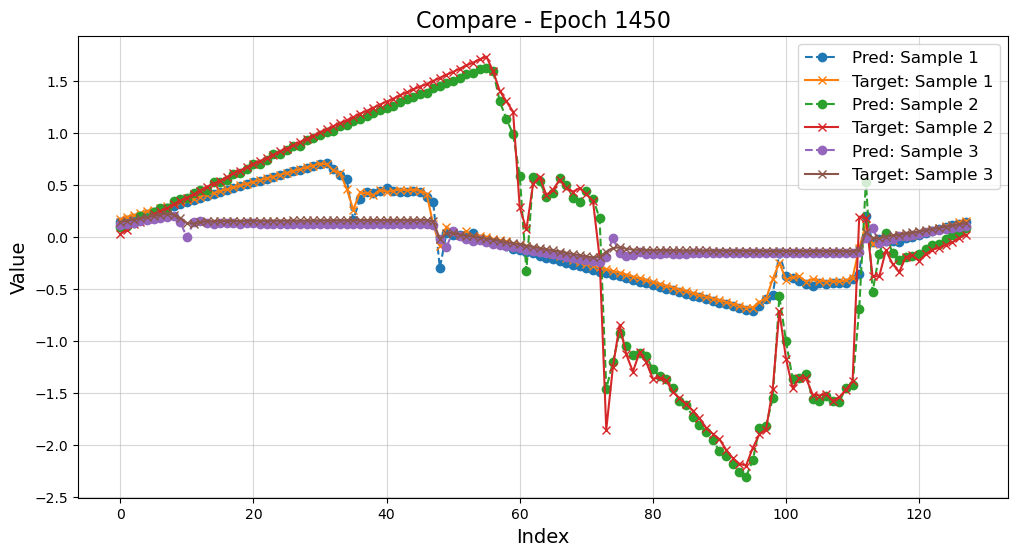

Epoch 1451, Train Loss: 0.006885, Validation Loss: 0.006984
Epoch 1452, Train Loss: 0.006919, Validation Loss: 0.006938
Epoch 1453, Train Loss: 0.006881, Validation Loss: 0.007802
Epoch 1454, Train Loss: 0.007172, Validation Loss: 0.007016
Epoch 1455, Train Loss: 0.006873, Validation Loss: 0.007285
Epoch 1456, Train Loss: 0.006869, Validation Loss: 0.007847
Epoch 1457, Train Loss: 0.007045, Validation Loss: 0.006893
Epoch 1458, Train Loss: 0.006822, Validation Loss: 0.006974
Epoch 1459, Train Loss: 0.006880, Validation Loss: 0.006922
Epoch 1460, Train Loss: 0.007078, Validation Loss: 0.007219
Epoch 1461, Train Loss: 0.006878, Validation Loss: 0.006851
Saving model at epoch 1461 with validation loss 0.006851...
Epoch 1462, Train Loss: 0.006823, Validation Loss: 0.007111
Epoch 1463, Train Loss: 0.006876, Validation Loss: 0.007017
Epoch 1464, Train Loss: 0.006890, Validation Loss: 0.006947
Epoch 1465, Train Loss: 0.006963, Validation Loss: 0.006903
Epoch 1466, Train Loss: 0.006974, Valida

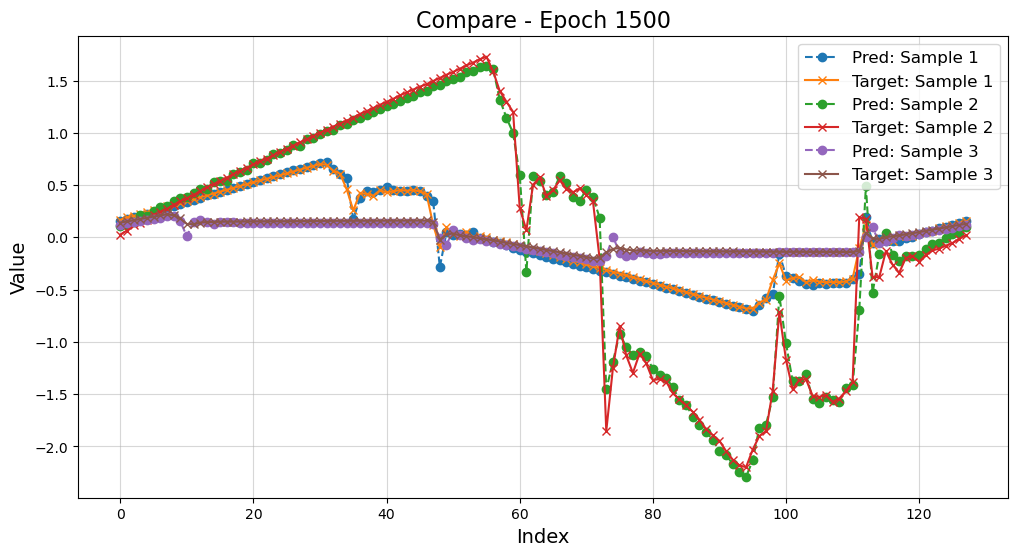

Epoch 1501, Train Loss: 0.006913, Validation Loss: 0.006877
Epoch 1502, Train Loss: 0.007188, Validation Loss: 0.007132
Epoch 1503, Train Loss: 0.006874, Validation Loss: 0.007458
Epoch 1504, Train Loss: 0.006934, Validation Loss: 0.007114
Epoch 1505, Train Loss: 0.006926, Validation Loss: 0.006963
Epoch 1506, Train Loss: 0.006875, Validation Loss: 0.006901
Epoch 1507, Train Loss: 0.006827, Validation Loss: 0.007295
Epoch 1508, Train Loss: 0.006993, Validation Loss: 0.006846
Saving model at epoch 1508 with validation loss 0.006846...
Epoch 1509, Train Loss: 0.006900, Validation Loss: 0.007176
Epoch 1510, Train Loss: 0.006927, Validation Loss: 0.006842
Saving model at epoch 1510 with validation loss 0.006842...
Epoch 1511, Train Loss: 0.006801, Validation Loss: 0.007046
Epoch 1512, Train Loss: 0.006963, Validation Loss: 0.007541
Epoch 1513, Train Loss: 0.006918, Validation Loss: 0.007024
Epoch 1514, Train Loss: 0.006782, Validation Loss: 0.007244
Epoch 1515, Train Loss: 0.006894, Valida

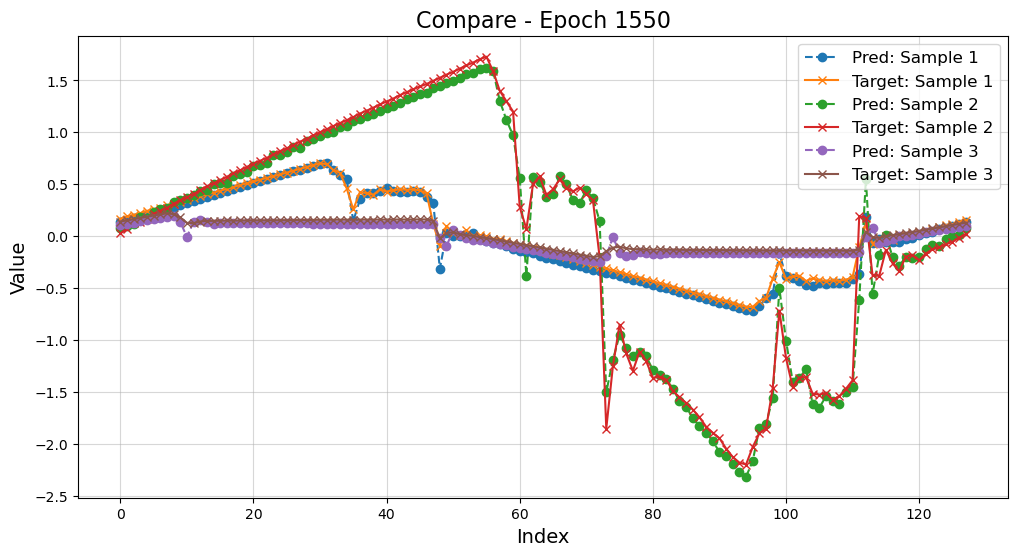

Epoch 1551, Train Loss: 0.006661, Validation Loss: 0.006883
Epoch 1552, Train Loss: 0.006747, Validation Loss: 0.006850
Epoch 1553, Train Loss: 0.006857, Validation Loss: 0.007211
Epoch 1554, Train Loss: 0.006826, Validation Loss: 0.006825
Epoch 1555, Train Loss: 0.006745, Validation Loss: 0.006952
Epoch 1556, Train Loss: 0.006838, Validation Loss: 0.006765
Epoch 1557, Train Loss: 0.006988, Validation Loss: 0.007126
Epoch 1558, Train Loss: 0.006904, Validation Loss: 0.006917
Epoch 1559, Train Loss: 0.006889, Validation Loss: 0.007229
Epoch 1560, Train Loss: 0.006744, Validation Loss: 0.006884
Epoch 1561, Train Loss: 0.006982, Validation Loss: 0.006887
Epoch 1562, Train Loss: 0.006931, Validation Loss: 0.006863
Epoch 1563, Train Loss: 0.006688, Validation Loss: 0.006767
Epoch 1564, Train Loss: 0.006916, Validation Loss: 0.006823
Epoch 1565, Train Loss: 0.006753, Validation Loss: 0.007245
Epoch 1566, Train Loss: 0.006708, Validation Loss: 0.007132
Epoch 1567, Train Loss: 0.006825, Valida

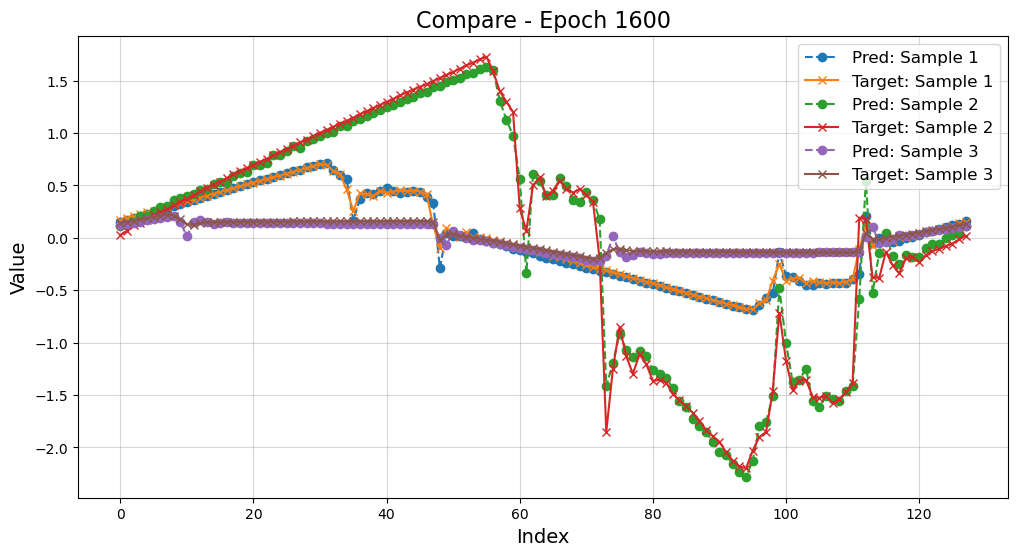

Epoch 1601, Train Loss: 0.006689, Validation Loss: 0.006904
Epoch 1602, Train Loss: 0.006627, Validation Loss: 0.006686
Epoch 1603, Train Loss: 0.006734, Validation Loss: 0.006933
Epoch 1604, Train Loss: 0.006998, Validation Loss: 0.008326
Epoch 1605, Train Loss: 0.006789, Validation Loss: 0.007082
Epoch 1606, Train Loss: 0.006876, Validation Loss: 0.007818
Epoch 1607, Train Loss: 0.006722, Validation Loss: 0.006976
Epoch 1608, Train Loss: 0.006715, Validation Loss: 0.006891
Epoch 1609, Train Loss: 0.006744, Validation Loss: 0.007557
Epoch 1610, Train Loss: 0.006722, Validation Loss: 0.006849
Epoch 1611, Train Loss: 0.006650, Validation Loss: 0.006851
Epoch 1612, Train Loss: 0.006634, Validation Loss: 0.006769
Epoch 1613, Train Loss: 0.006628, Validation Loss: 0.006897
Epoch 1614, Train Loss: 0.006723, Validation Loss: 0.007401
Epoch 1615, Train Loss: 0.006604, Validation Loss: 0.006725
Epoch 1616, Train Loss: 0.006791, Validation Loss: 0.006810
Epoch 1617, Train Loss: 0.006704, Valida

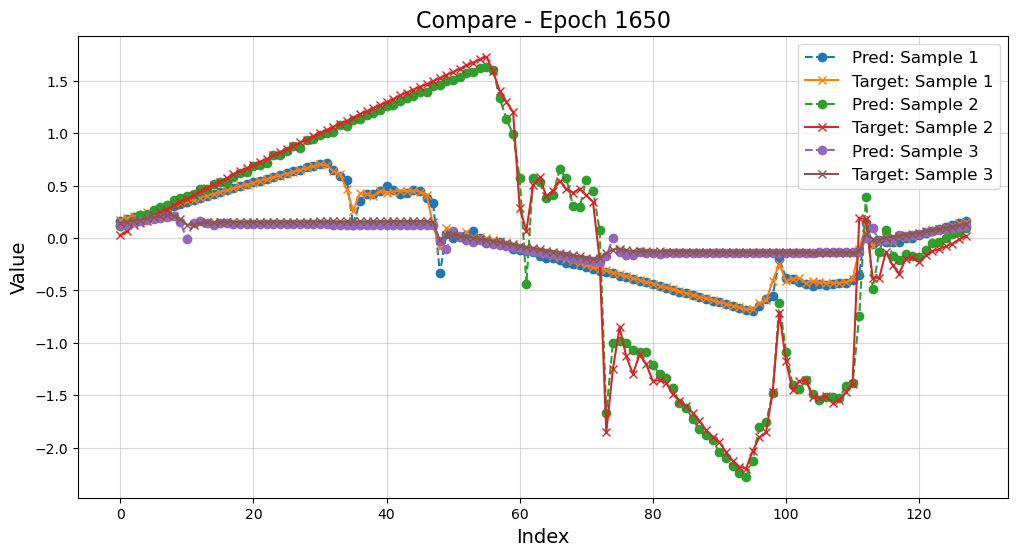

Epoch 1651, Train Loss: 0.006700, Validation Loss: 0.007055
Epoch 1652, Train Loss: 0.006639, Validation Loss: 0.006976
Epoch 1653, Train Loss: 0.006567, Validation Loss: 0.006621
Saving model at epoch 1653 with validation loss 0.006621...
Epoch 1654, Train Loss: 0.006632, Validation Loss: 0.007422
Epoch 1655, Train Loss: 0.006683, Validation Loss: 0.007110
Epoch 1656, Train Loss: 0.006633, Validation Loss: 0.006803
Epoch 1657, Train Loss: 0.006765, Validation Loss: 0.006658
Epoch 1658, Train Loss: 0.006618, Validation Loss: 0.006848
Epoch 1659, Train Loss: 0.006670, Validation Loss: 0.006719
Epoch 1660, Train Loss: 0.006705, Validation Loss: 0.006752
Epoch 1661, Train Loss: 0.006783, Validation Loss: 0.006902
Epoch 1662, Train Loss: 0.006718, Validation Loss: 0.007114
Epoch 1663, Train Loss: 0.006761, Validation Loss: 0.006853
Epoch 1664, Train Loss: 0.006732, Validation Loss: 0.007281
Epoch 1665, Train Loss: 0.006703, Validation Loss: 0.006738
Epoch 1666, Train Loss: 0.006763, Valida

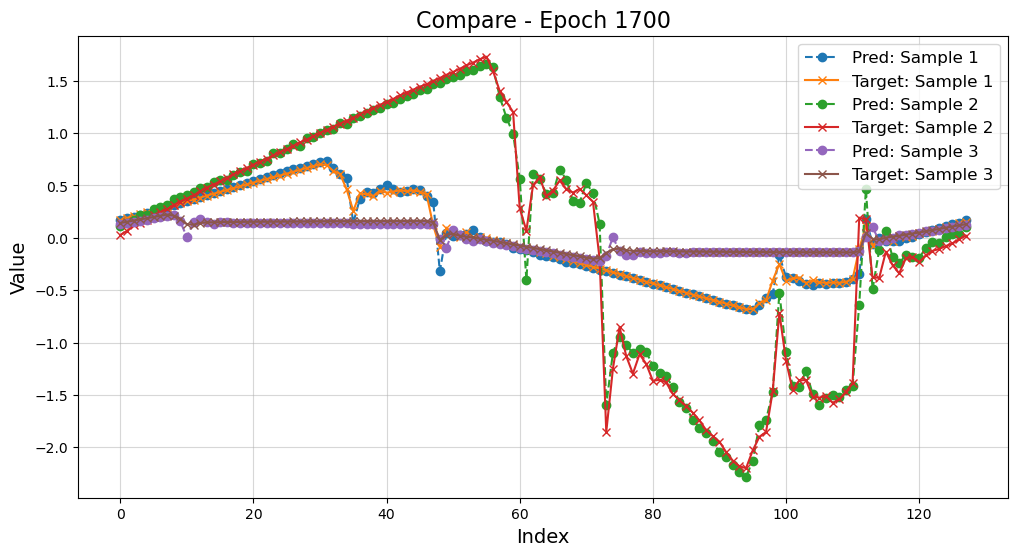

Epoch 1701, Train Loss: 0.006537, Validation Loss: 0.006754
Epoch 1702, Train Loss: 0.006583, Validation Loss: 0.006608
Epoch 1703, Train Loss: 0.006603, Validation Loss: 0.006656
Epoch 1704, Train Loss: 0.006544, Validation Loss: 0.006676
Epoch 1705, Train Loss: 0.006612, Validation Loss: 0.007612
Epoch 1706, Train Loss: 0.006812, Validation Loss: 0.006819
Epoch 1707, Train Loss: 0.006652, Validation Loss: 0.006653
Epoch 1708, Train Loss: 0.006587, Validation Loss: 0.006707
Epoch 1709, Train Loss: 0.006467, Validation Loss: 0.007109
Epoch 1710, Train Loss: 0.006616, Validation Loss: 0.007080
Epoch 1711, Train Loss: 0.006763, Validation Loss: 0.006911
Epoch 1712, Train Loss: 0.006522, Validation Loss: 0.006820
Epoch 1713, Train Loss: 0.006542, Validation Loss: 0.006815
Epoch 1714, Train Loss: 0.006748, Validation Loss: 0.007531
Epoch 1715, Train Loss: 0.006583, Validation Loss: 0.006861
Epoch 1716, Train Loss: 0.006668, Validation Loss: 0.006924
Epoch 1717, Train Loss: 0.006547, Valida

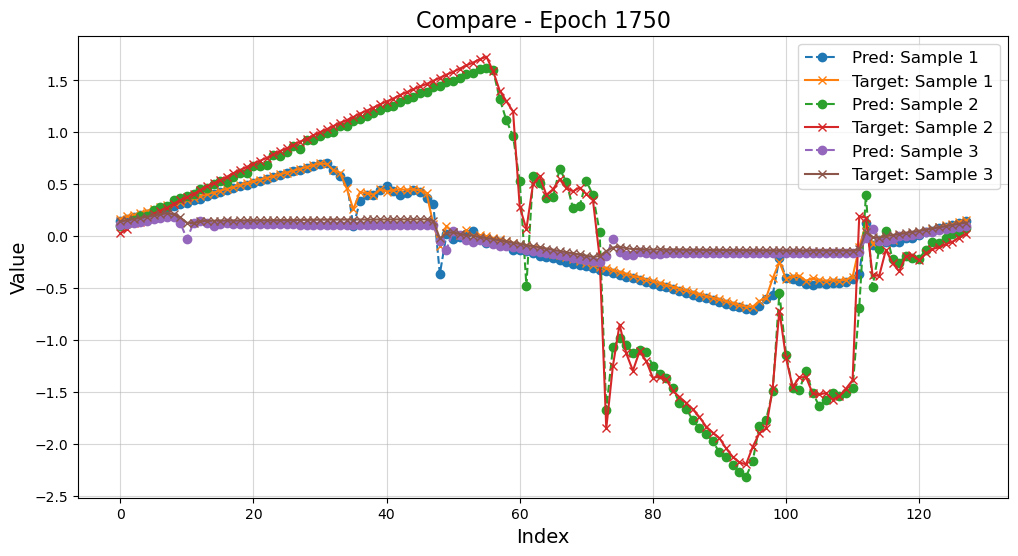

Epoch 1751, Train Loss: 0.006605, Validation Loss: 0.006827
Epoch 1752, Train Loss: 0.006512, Validation Loss: 0.008054
Epoch 1753, Train Loss: 0.006605, Validation Loss: 0.006565
Epoch 1754, Train Loss: 0.006520, Validation Loss: 0.007069
Epoch 1755, Train Loss: 0.006577, Validation Loss: 0.006699
Epoch 1756, Train Loss: 0.006691, Validation Loss: 0.006907
Epoch 1757, Train Loss: 0.006651, Validation Loss: 0.006851
Epoch 1758, Train Loss: 0.006562, Validation Loss: 0.006856
Epoch 1759, Train Loss: 0.006572, Validation Loss: 0.006993
Epoch 1760, Train Loss: 0.006551, Validation Loss: 0.006735
Epoch 1761, Train Loss: 0.006658, Validation Loss: 0.006795
Epoch 1762, Train Loss: 0.006511, Validation Loss: 0.006590
Epoch 1763, Train Loss: 0.006427, Validation Loss: 0.006653
Epoch 1764, Train Loss: 0.006494, Validation Loss: 0.007476
Epoch 1765, Train Loss: 0.006481, Validation Loss: 0.006746
Epoch 1766, Train Loss: 0.006473, Validation Loss: 0.007124
Epoch 1767, Train Loss: 0.006782, Valida

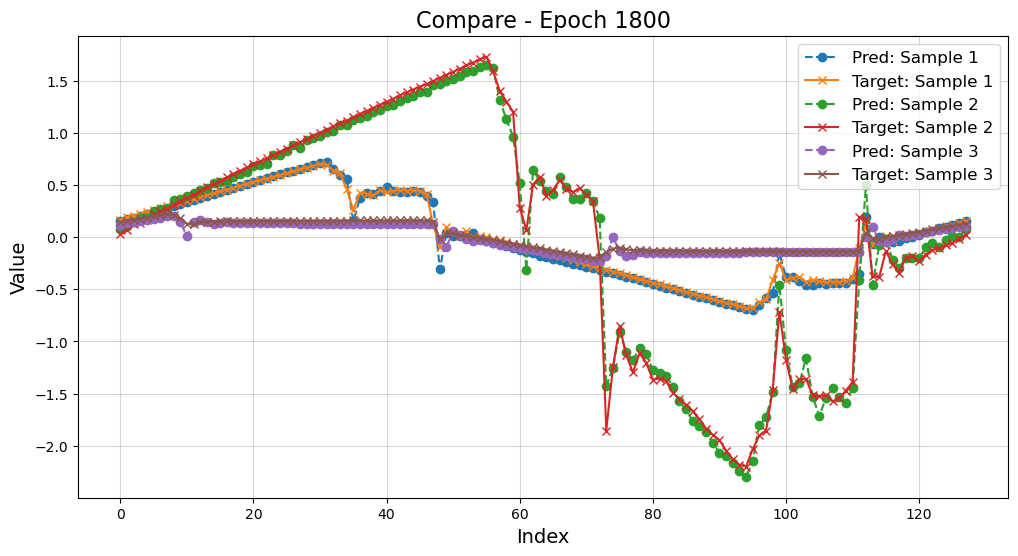

Epoch 1801, Train Loss: 0.006493, Validation Loss: 0.006663
Epoch 1802, Train Loss: 0.006441, Validation Loss: 0.006537
Epoch 1803, Train Loss: 0.006369, Validation Loss: 0.006652
Epoch 1804, Train Loss: 0.006612, Validation Loss: 0.006635
Epoch 1805, Train Loss: 0.006459, Validation Loss: 0.006800
Epoch 1806, Train Loss: 0.006433, Validation Loss: 0.006816
Epoch 1807, Train Loss: 0.006422, Validation Loss: 0.006703
Epoch 1808, Train Loss: 0.006495, Validation Loss: 0.007307
Epoch 1809, Train Loss: 0.006492, Validation Loss: 0.006899
Epoch 1810, Train Loss: 0.006431, Validation Loss: 0.006503
Epoch 1811, Train Loss: 0.006530, Validation Loss: 0.006672
Epoch 1812, Train Loss: 0.006638, Validation Loss: 0.007189
Epoch 1813, Train Loss: 0.006504, Validation Loss: 0.006590
Epoch 1814, Train Loss: 0.006486, Validation Loss: 0.006743
Epoch 1815, Train Loss: 0.006557, Validation Loss: 0.006595
Epoch 1816, Train Loss: 0.006623, Validation Loss: 0.006906
Epoch 1817, Train Loss: 0.006455, Valida

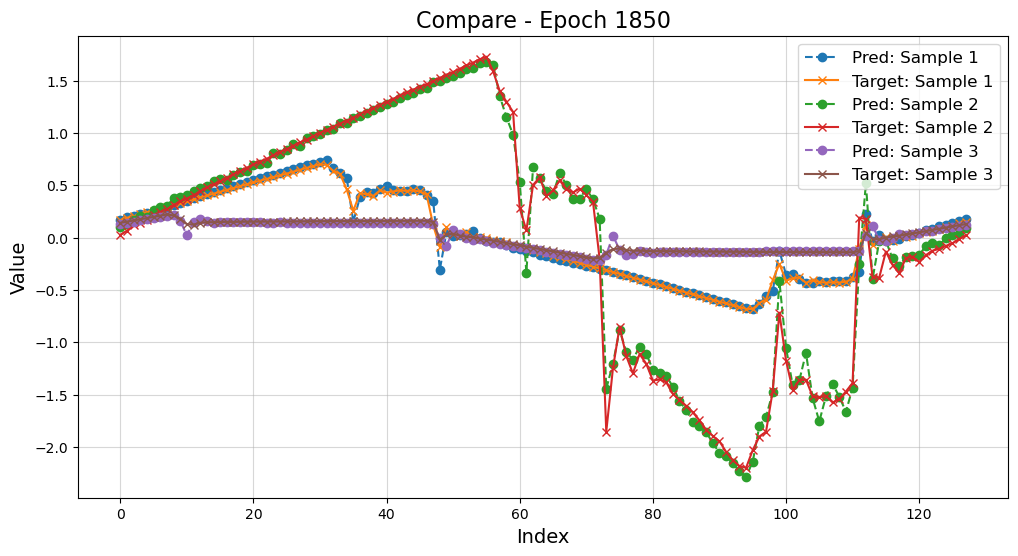

Epoch 1851, Train Loss: 0.006498, Validation Loss: 0.006749
Epoch 1852, Train Loss: 0.006551, Validation Loss: 0.007083
Epoch 1853, Train Loss: 0.006419, Validation Loss: 0.006660
Epoch 1854, Train Loss: 0.006346, Validation Loss: 0.006738
Epoch 1855, Train Loss: 0.006512, Validation Loss: 0.007141
Epoch 1856, Train Loss: 0.006653, Validation Loss: 0.006582
Epoch 1857, Train Loss: 0.006555, Validation Loss: 0.006451
Saving model at epoch 1857 with validation loss 0.006451...
Epoch 1858, Train Loss: 0.006502, Validation Loss: 0.007126
Epoch 1859, Train Loss: 0.006544, Validation Loss: 0.006649
Epoch 1860, Train Loss: 0.006332, Validation Loss: 0.007001
Epoch 1861, Train Loss: 0.006523, Validation Loss: 0.006806
Epoch 1862, Train Loss: 0.006500, Validation Loss: 0.006781
Epoch 1863, Train Loss: 0.006392, Validation Loss: 0.007617
Epoch 1864, Train Loss: 0.006606, Validation Loss: 0.007120
Epoch 1865, Train Loss: 0.006451, Validation Loss: 0.006704
Epoch 1866, Train Loss: 0.006548, Valida

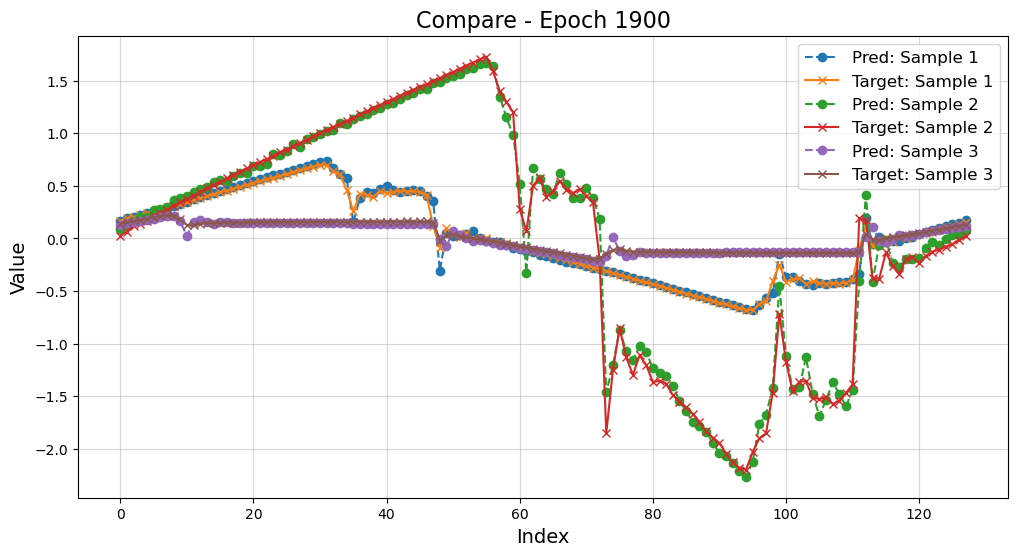

Epoch 1901, Train Loss: 0.006341, Validation Loss: 0.006584
Epoch 1902, Train Loss: 0.006322, Validation Loss: 0.006683
Epoch 1903, Train Loss: 0.006371, Validation Loss: 0.006600
Epoch 1904, Train Loss: 0.006434, Validation Loss: 0.006620
Epoch 1905, Train Loss: 0.006578, Validation Loss: 0.006493
Epoch 1906, Train Loss: 0.006382, Validation Loss: 0.007027
Epoch 1907, Train Loss: 0.006497, Validation Loss: 0.006547
Epoch 1908, Train Loss: 0.006310, Validation Loss: 0.006637
Epoch 1909, Train Loss: 0.006321, Validation Loss: 0.006467
Epoch 1910, Train Loss: 0.006432, Validation Loss: 0.006923
Epoch 1911, Train Loss: 0.006425, Validation Loss: 0.006530
Epoch 1912, Train Loss: 0.006368, Validation Loss: 0.006628
Epoch 1913, Train Loss: 0.006312, Validation Loss: 0.007041
Epoch 1914, Train Loss: 0.006509, Validation Loss: 0.006581
Epoch 1915, Train Loss: 0.006518, Validation Loss: 0.006922
Epoch 1916, Train Loss: 0.006373, Validation Loss: 0.006794
Epoch 1917, Train Loss: 0.006346, Valida

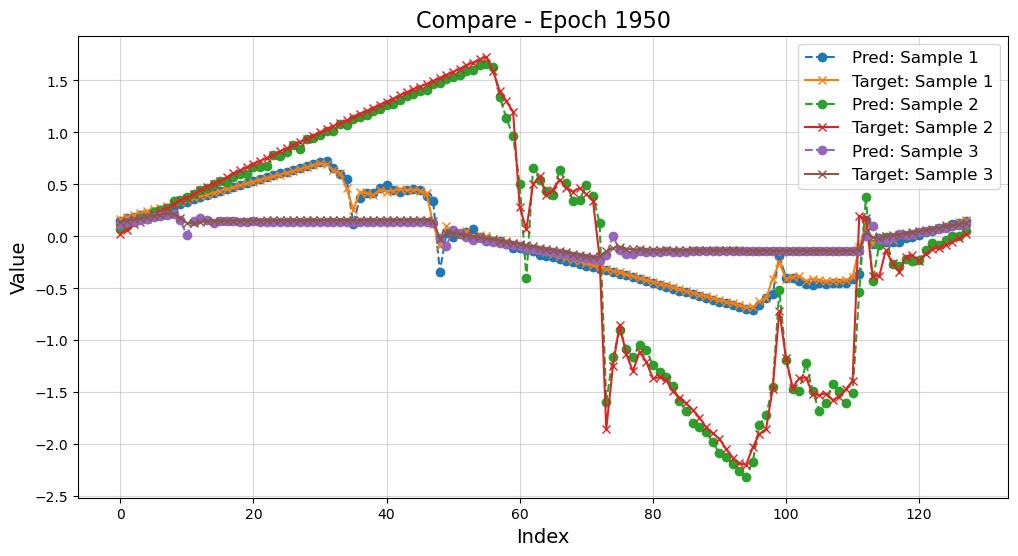

Epoch 1951, Train Loss: 0.006359, Validation Loss: 0.006628
Epoch 1952, Train Loss: 0.006484, Validation Loss: 0.006558
Epoch 1953, Train Loss: 0.006250, Validation Loss: 0.006653
Epoch 1954, Train Loss: 0.006273, Validation Loss: 0.006436
Epoch 1955, Train Loss: 0.006282, Validation Loss: 0.006544
Epoch 1956, Train Loss: 0.006385, Validation Loss: 0.006586
Epoch 1957, Train Loss: 0.006341, Validation Loss: 0.006419
Epoch 1958, Train Loss: 0.006297, Validation Loss: 0.006616
Epoch 1959, Train Loss: 0.006455, Validation Loss: 0.006640
Epoch 1960, Train Loss: 0.006421, Validation Loss: 0.007271
Epoch 1961, Train Loss: 0.006730, Validation Loss: 0.006454
Epoch 1962, Train Loss: 0.006240, Validation Loss: 0.006573
Epoch 1963, Train Loss: 0.006286, Validation Loss: 0.006640
Epoch 1964, Train Loss: 0.006302, Validation Loss: 0.006366
Epoch 1965, Train Loss: 0.006265, Validation Loss: 0.006413
Epoch 1966, Train Loss: 0.006373, Validation Loss: 0.006493
Epoch 1967, Train Loss: 0.006256, Valida

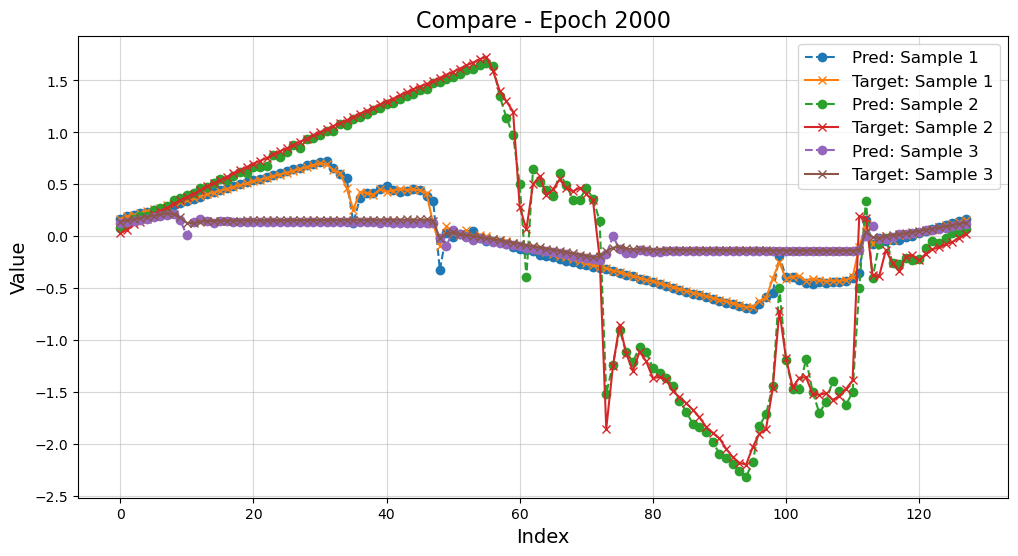

Epoch 2001, Train Loss: 0.006274, Validation Loss: 0.006346
Epoch 2002, Train Loss: 0.006411, Validation Loss: 0.007773
Epoch 2003, Train Loss: 0.006351, Validation Loss: 0.007087
Epoch 2004, Train Loss: 0.006267, Validation Loss: 0.006423
Epoch 2005, Train Loss: 0.006213, Validation Loss: 0.007316
Epoch 2006, Train Loss: 0.006467, Validation Loss: 0.006541
Epoch 2007, Train Loss: 0.006265, Validation Loss: 0.006689
Epoch 2008, Train Loss: 0.006274, Validation Loss: 0.007307
Epoch 2009, Train Loss: 0.006244, Validation Loss: 0.006367
Epoch 2010, Train Loss: 0.006201, Validation Loss: 0.006588
Epoch 2011, Train Loss: 0.006379, Validation Loss: 0.006618
Epoch 2012, Train Loss: 0.006464, Validation Loss: 0.007353
Epoch 2013, Train Loss: 0.006369, Validation Loss: 0.006584
Epoch 2014, Train Loss: 0.006248, Validation Loss: 0.006417
Epoch 2015, Train Loss: 0.006206, Validation Loss: 0.006540
Epoch 2016, Train Loss: 0.006302, Validation Loss: 0.007586
Epoch 2017, Train Loss: 0.006281, Valida

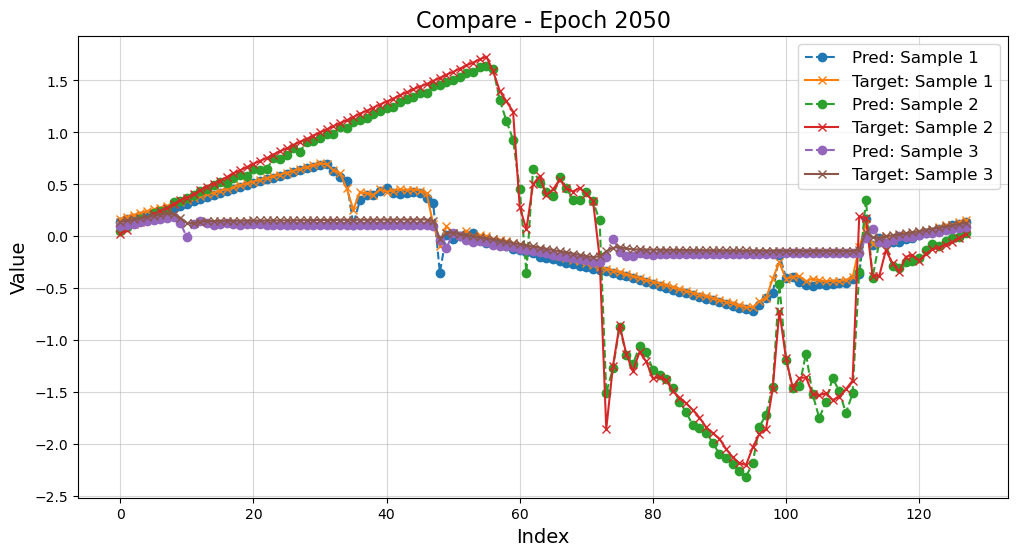

Epoch 2051, Train Loss: 0.006357, Validation Loss: 0.006874
Epoch 2052, Train Loss: 0.006331, Validation Loss: 0.007139
Epoch 2053, Train Loss: 0.006368, Validation Loss: 0.006326
Epoch 2054, Train Loss: 0.006178, Validation Loss: 0.006399
Epoch 2055, Train Loss: 0.006153, Validation Loss: 0.006652
Epoch 2056, Train Loss: 0.006253, Validation Loss: 0.006532
Epoch 2057, Train Loss: 0.006245, Validation Loss: 0.006705
Epoch 2058, Train Loss: 0.006336, Validation Loss: 0.006600
Epoch 2059, Train Loss: 0.006220, Validation Loss: 0.006573
Epoch 2060, Train Loss: 0.006201, Validation Loss: 0.006530
Epoch 2061, Train Loss: 0.006239, Validation Loss: 0.006793
Epoch 2062, Train Loss: 0.006120, Validation Loss: 0.006364
Epoch 2063, Train Loss: 0.006211, Validation Loss: 0.007533
Epoch 2064, Train Loss: 0.006228, Validation Loss: 0.006337
Epoch 2065, Train Loss: 0.006184, Validation Loss: 0.006394
Epoch 2066, Train Loss: 0.006205, Validation Loss: 0.006536
Epoch 2067, Train Loss: 0.006258, Valida

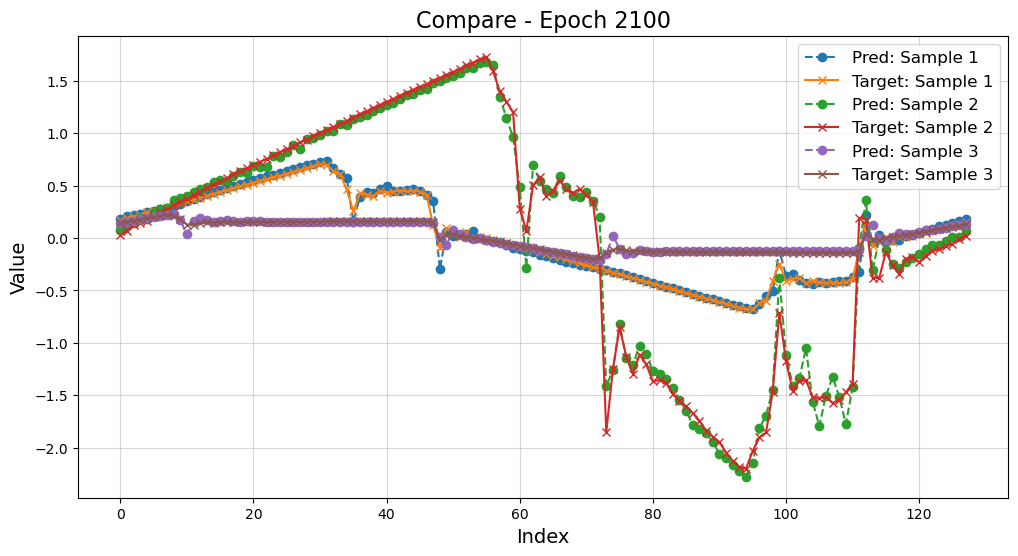

Epoch 2101, Train Loss: 0.006468, Validation Loss: 0.006396
Epoch 2102, Train Loss: 0.006187, Validation Loss: 0.006295
Epoch 2103, Train Loss: 0.006120, Validation Loss: 0.006393
Epoch 2104, Train Loss: 0.006202, Validation Loss: 0.006575
Epoch 2105, Train Loss: 0.006168, Validation Loss: 0.006616
Epoch 2106, Train Loss: 0.006275, Validation Loss: 0.006561
Epoch 2107, Train Loss: 0.006301, Validation Loss: 0.006605
Epoch 2108, Train Loss: 0.006152, Validation Loss: 0.006375
Epoch 2109, Train Loss: 0.006185, Validation Loss: 0.006617
Epoch 2110, Train Loss: 0.006325, Validation Loss: 0.006530
Epoch 2111, Train Loss: 0.006351, Validation Loss: 0.006882
Epoch 2112, Train Loss: 0.006661, Validation Loss: 0.006647
Epoch 2113, Train Loss: 0.006243, Validation Loss: 0.006490
Epoch 2114, Train Loss: 0.006196, Validation Loss: 0.006305
Epoch 2115, Train Loss: 0.006193, Validation Loss: 0.006424
Epoch 2116, Train Loss: 0.006127, Validation Loss: 0.006417
Epoch 2117, Train Loss: 0.006251, Valida

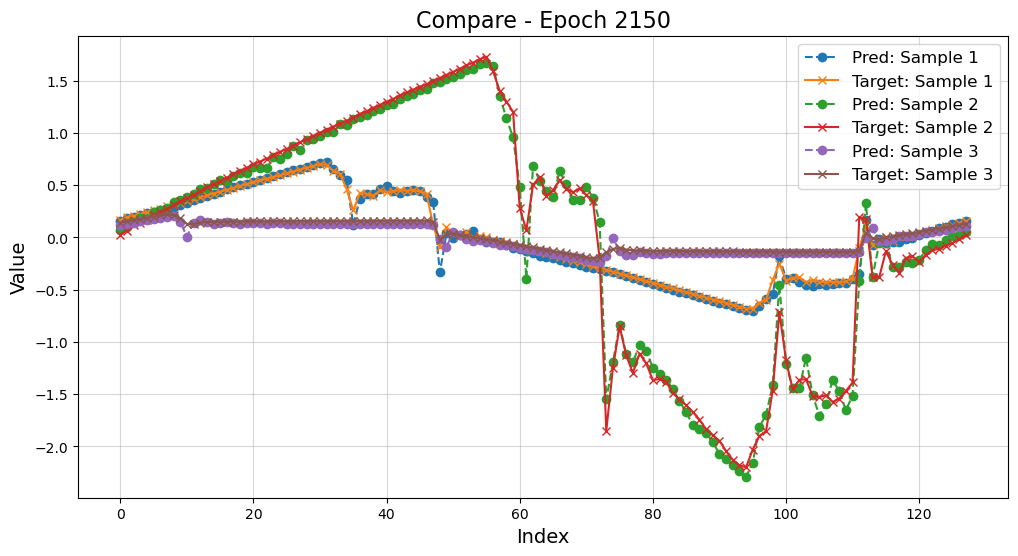

Epoch 2151, Train Loss: 0.006250, Validation Loss: 0.006756
Epoch 2152, Train Loss: 0.006376, Validation Loss: 0.006488
Epoch 2153, Train Loss: 0.006215, Validation Loss: 0.006371
Epoch 2154, Train Loss: 0.006164, Validation Loss: 0.007014
Epoch 2155, Train Loss: 0.006157, Validation Loss: 0.006660
Epoch 2156, Train Loss: 0.006108, Validation Loss: 0.006288
Epoch 2157, Train Loss: 0.006222, Validation Loss: 0.006451
Epoch 2158, Train Loss: 0.006253, Validation Loss: 0.006483
Epoch 2159, Train Loss: 0.006243, Validation Loss: 0.007331
Epoch 2160, Train Loss: 0.006210, Validation Loss: 0.006349
Epoch 2161, Train Loss: 0.006220, Validation Loss: 0.006381
Epoch 2162, Train Loss: 0.006215, Validation Loss: 0.006317
Epoch 2163, Train Loss: 0.006064, Validation Loss: 0.006350
Epoch 2164, Train Loss: 0.006066, Validation Loss: 0.006458
Epoch 2165, Train Loss: 0.006109, Validation Loss: 0.006302
Epoch 2166, Train Loss: 0.006290, Validation Loss: 0.007021
Epoch 2167, Train Loss: 0.006729, Valida

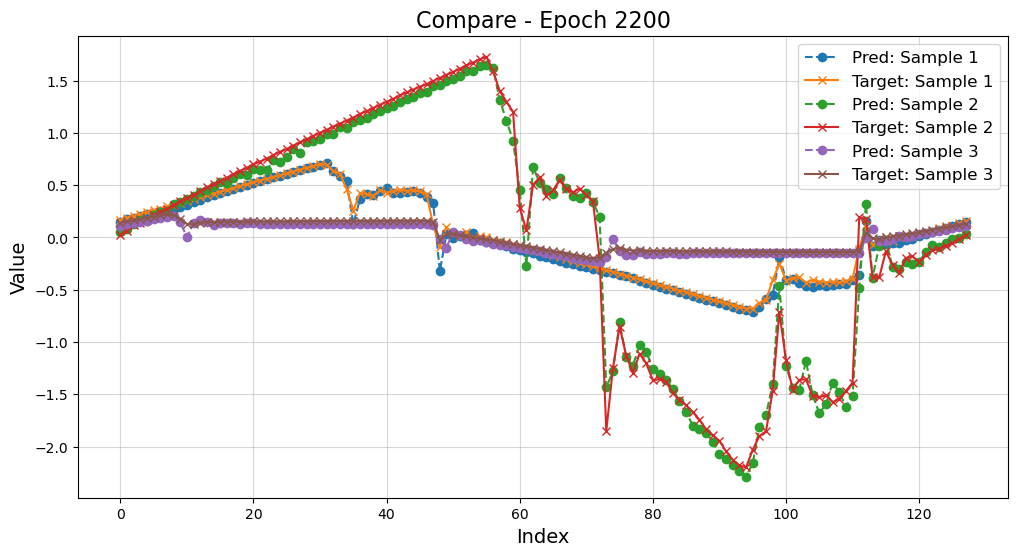

Epoch 2201, Train Loss: 0.006142, Validation Loss: 0.006278
Epoch 2202, Train Loss: 0.006092, Validation Loss: 0.007424
Epoch 2203, Train Loss: 0.006255, Validation Loss: 0.006835
Epoch 2204, Train Loss: 0.006505, Validation Loss: 0.006349
Epoch 2205, Train Loss: 0.006212, Validation Loss: 0.006211
Epoch 2206, Train Loss: 0.006094, Validation Loss: 0.006466
Epoch 2207, Train Loss: 0.006038, Validation Loss: 0.006319
Epoch 2208, Train Loss: 0.006067, Validation Loss: 0.006413
Epoch 2209, Train Loss: 0.006096, Validation Loss: 0.006200
Saving model at epoch 2209 with validation loss 0.006200...
Epoch 2210, Train Loss: 0.006304, Validation Loss: 0.006372
Epoch 2211, Train Loss: 0.006221, Validation Loss: 0.006301
Epoch 2212, Train Loss: 0.006099, Validation Loss: 0.006345
Epoch 2213, Train Loss: 0.006160, Validation Loss: 0.006245
Epoch 2214, Train Loss: 0.005999, Validation Loss: 0.006344
Epoch 2215, Train Loss: 0.006203, Validation Loss: 0.006299
Epoch 2216, Train Loss: 0.006092, Valida

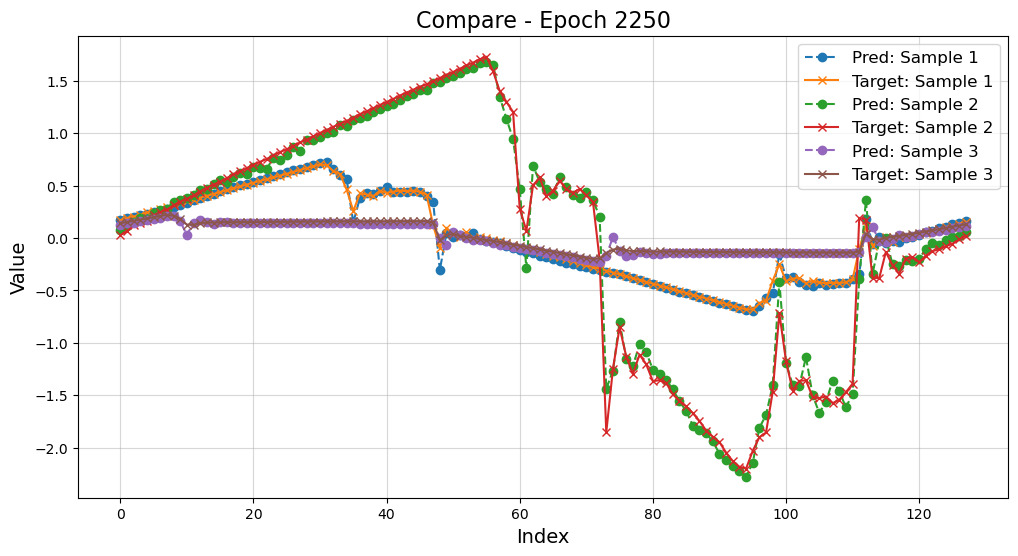

Epoch 2251, Train Loss: 0.006191, Validation Loss: 0.006733
Epoch 2252, Train Loss: 0.006053, Validation Loss: 0.006351
Epoch 2253, Train Loss: 0.006098, Validation Loss: 0.006990
Epoch 2254, Train Loss: 0.006002, Validation Loss: 0.006465
Epoch 2255, Train Loss: 0.006398, Validation Loss: 0.008551
Epoch 2256, Train Loss: 0.006516, Validation Loss: 0.006575
Epoch 2257, Train Loss: 0.006100, Validation Loss: 0.006445
Epoch 2258, Train Loss: 0.006101, Validation Loss: 0.006409
Epoch 2259, Train Loss: 0.006146, Validation Loss: 0.006151
Epoch 2260, Train Loss: 0.005961, Validation Loss: 0.006290
Epoch 2261, Train Loss: 0.006188, Validation Loss: 0.006393
Epoch 2262, Train Loss: 0.006340, Validation Loss: 0.006655
Epoch 2263, Train Loss: 0.006174, Validation Loss: 0.006226
Epoch 2264, Train Loss: 0.006067, Validation Loss: 0.006218
Epoch 2265, Train Loss: 0.006223, Validation Loss: 0.006588
Epoch 2266, Train Loss: 0.006184, Validation Loss: 0.006879
Epoch 2267, Train Loss: 0.006222, Valida

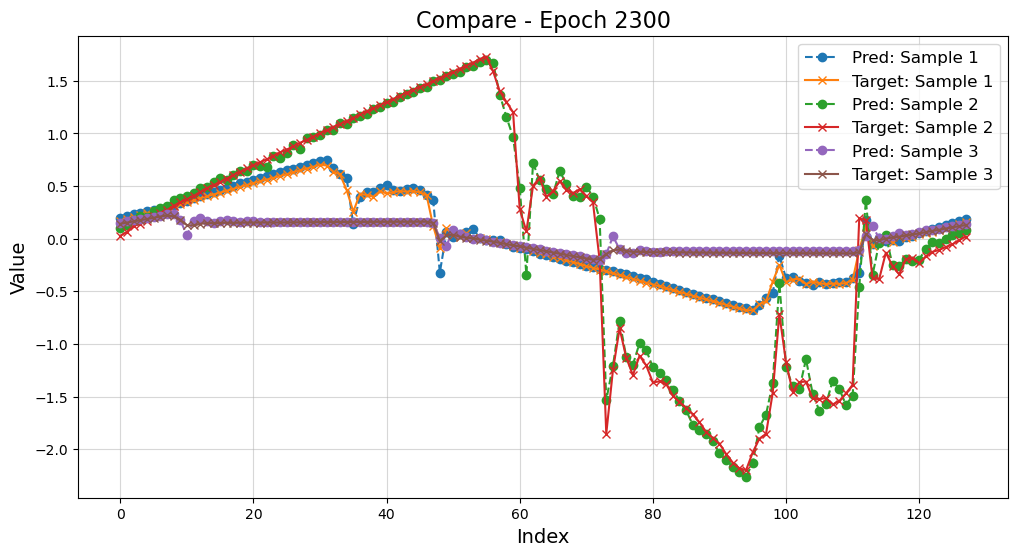

Epoch 2301, Train Loss: 0.006098, Validation Loss: 0.006183
Epoch 2302, Train Loss: 0.006182, Validation Loss: 0.006628
Epoch 2303, Train Loss: 0.006012, Validation Loss: 0.006390
Epoch 2304, Train Loss: 0.006182, Validation Loss: 0.006449
Epoch 2305, Train Loss: 0.005909, Validation Loss: 0.006219
Epoch 2306, Train Loss: 0.006036, Validation Loss: 0.006272
Epoch 2307, Train Loss: 0.006143, Validation Loss: 0.006491
Epoch 2308, Train Loss: 0.006052, Validation Loss: 0.006309
Epoch 2309, Train Loss: 0.006300, Validation Loss: 0.007099
Epoch 2310, Train Loss: 0.006291, Validation Loss: 0.006946
Epoch 2311, Train Loss: 0.006171, Validation Loss: 0.006332
Epoch 2312, Train Loss: 0.006100, Validation Loss: 0.006651
Epoch 2313, Train Loss: 0.005998, Validation Loss: 0.006150
Epoch 2314, Train Loss: 0.006049, Validation Loss: 0.006698
Epoch 2315, Train Loss: 0.006149, Validation Loss: 0.006836
Epoch 2316, Train Loss: 0.006116, Validation Loss: 0.006215
Epoch 2317, Train Loss: 0.006054, Valida

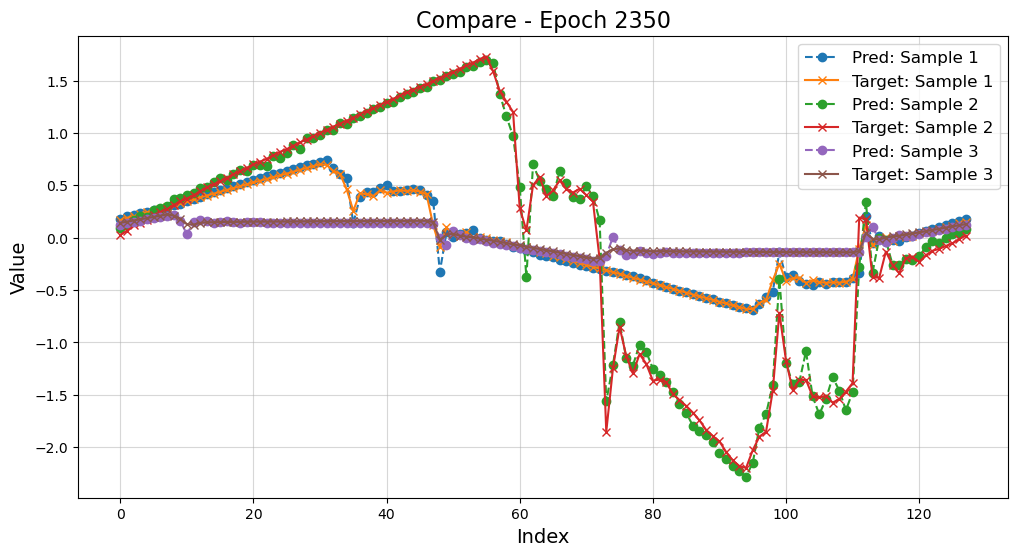

Epoch 2351, Train Loss: 0.006135, Validation Loss: 0.006196
Epoch 2352, Train Loss: 0.005934, Validation Loss: 0.006232
Epoch 2353, Train Loss: 0.005968, Validation Loss: 0.006354
Epoch 2354, Train Loss: 0.006049, Validation Loss: 0.006189
Epoch 2355, Train Loss: 0.005976, Validation Loss: 0.006150
Epoch 2356, Train Loss: 0.006155, Validation Loss: 0.006632
Epoch 2357, Train Loss: 0.005993, Validation Loss: 0.006145
Epoch 2358, Train Loss: 0.006233, Validation Loss: 0.006234
Epoch 2359, Train Loss: 0.006043, Validation Loss: 0.006336
Epoch 2360, Train Loss: 0.006056, Validation Loss: 0.006370
Epoch 2361, Train Loss: 0.006077, Validation Loss: 0.006302
Epoch 2362, Train Loss: 0.006143, Validation Loss: 0.007683
Epoch 2363, Train Loss: 0.006113, Validation Loss: 0.006159
Epoch 2364, Train Loss: 0.006078, Validation Loss: 0.007062
Epoch 2365, Train Loss: 0.006074, Validation Loss: 0.006216
Epoch 2366, Train Loss: 0.005974, Validation Loss: 0.006240
Epoch 2367, Train Loss: 0.005990, Valida

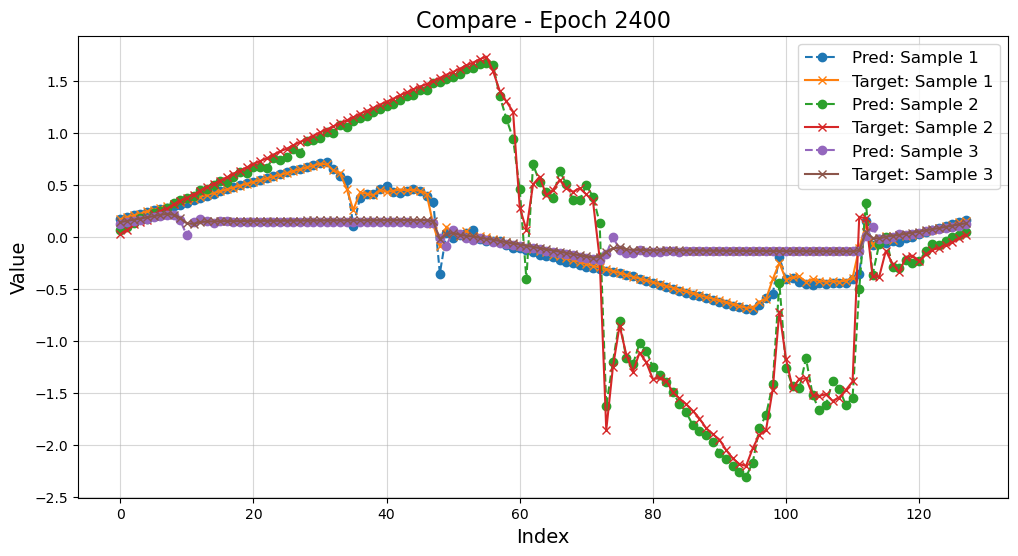

Epoch 2401, Train Loss: 0.006005, Validation Loss: 0.006651
Epoch 2402, Train Loss: 0.006144, Validation Loss: 0.010917
Epoch 2403, Train Loss: 0.006423, Validation Loss: 0.006255
Epoch 2404, Train Loss: 0.005981, Validation Loss: 0.006179
Epoch 2405, Train Loss: 0.006035, Validation Loss: 0.006454
Epoch 2406, Train Loss: 0.005985, Validation Loss: 0.006242
Epoch 2407, Train Loss: 0.005973, Validation Loss: 0.006168
Epoch 2408, Train Loss: 0.005910, Validation Loss: 0.006232
Epoch 2409, Train Loss: 0.005865, Validation Loss: 0.006175
Epoch 2410, Train Loss: 0.005968, Validation Loss: 0.006358
Epoch 2411, Train Loss: 0.005999, Validation Loss: 0.006585
Epoch 2412, Train Loss: 0.006118, Validation Loss: 0.007993
Epoch 2413, Train Loss: 0.006217, Validation Loss: 0.006302
Epoch 2414, Train Loss: 0.006195, Validation Loss: 0.006364
Epoch 2415, Train Loss: 0.006156, Validation Loss: 0.006129
Epoch 2416, Train Loss: 0.006098, Validation Loss: 0.006147
Epoch 2417, Train Loss: 0.006057, Valida

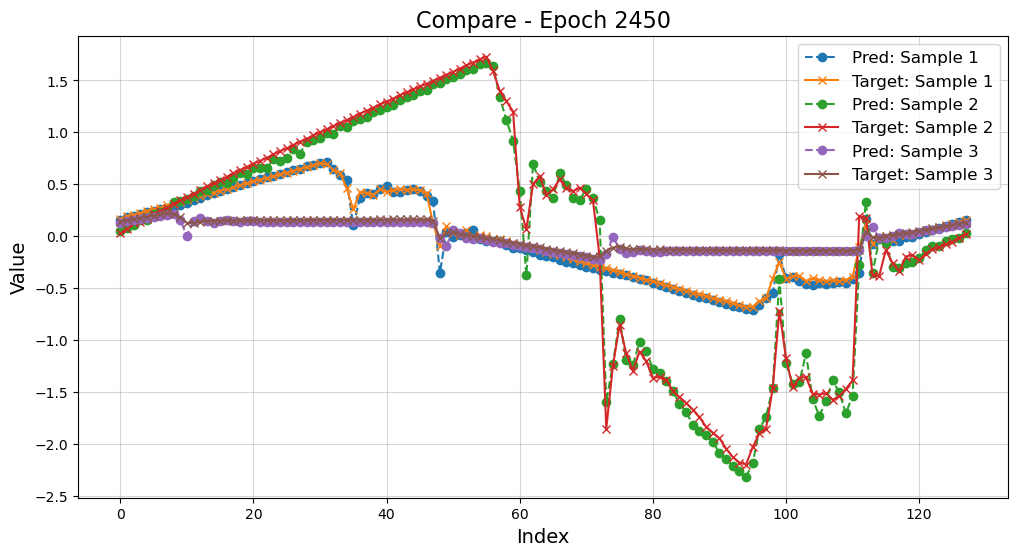

Epoch 2451, Train Loss: 0.006034, Validation Loss: 0.006522
Epoch 2452, Train Loss: 0.006196, Validation Loss: 0.006363
Epoch 2453, Train Loss: 0.006012, Validation Loss: 0.006952
Epoch 2454, Train Loss: 0.006044, Validation Loss: 0.006749
Epoch 2455, Train Loss: 0.006001, Validation Loss: 0.006092
Saving model at epoch 2455 with validation loss 0.006092...
Epoch 2456, Train Loss: 0.005864, Validation Loss: 0.006282
Epoch 2457, Train Loss: 0.005922, Validation Loss: 0.006265
Epoch 2458, Train Loss: 0.006007, Validation Loss: 0.006215
Epoch 2459, Train Loss: 0.005957, Validation Loss: 0.006771
Epoch 2460, Train Loss: 0.006044, Validation Loss: 0.006244
Epoch 2461, Train Loss: 0.005883, Validation Loss: 0.006389
Epoch 2462, Train Loss: 0.006011, Validation Loss: 0.006500
Epoch 2463, Train Loss: 0.006095, Validation Loss: 0.006717
Epoch 2464, Train Loss: 0.006094, Validation Loss: 0.006390
Epoch 2465, Train Loss: 0.005990, Validation Loss: 0.006356
Epoch 2466, Train Loss: 0.006406, Valida

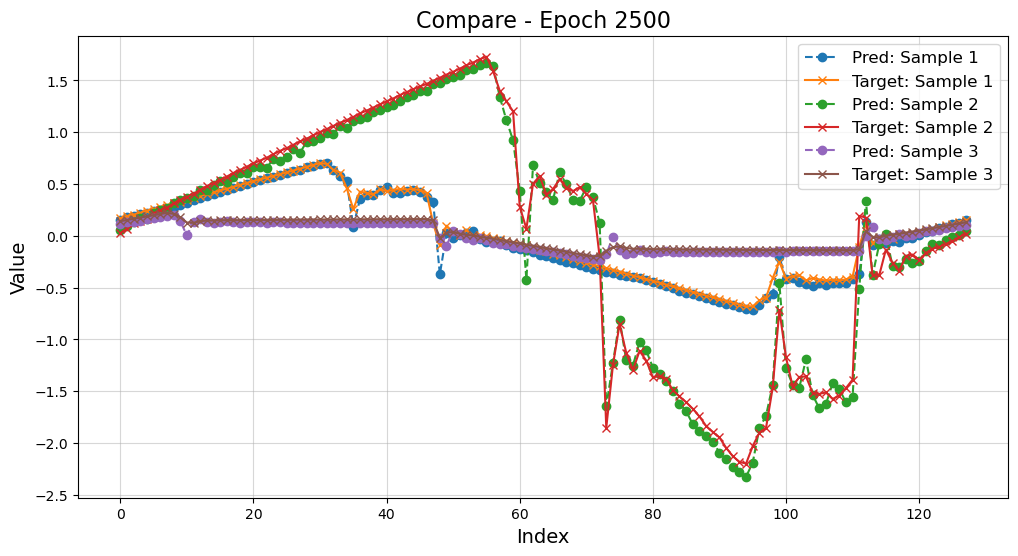

Epoch 2501, Train Loss: 0.005905, Validation Loss: 0.006361
Epoch 2502, Train Loss: 0.006008, Validation Loss: 0.006343
Epoch 2503, Train Loss: 0.005862, Validation Loss: 0.006181
Epoch 2504, Train Loss: 0.006311, Validation Loss: 0.006175
Epoch 2505, Train Loss: 0.006095, Validation Loss: 0.006470
Epoch 2506, Train Loss: 0.005962, Validation Loss: 0.006155
Epoch 2507, Train Loss: 0.005947, Validation Loss: 0.006351
Epoch 2508, Train Loss: 0.006238, Validation Loss: 0.006049
Saving model at epoch 2508 with validation loss 0.006049...
Epoch 2509, Train Loss: 0.006019, Validation Loss: 0.006106
Epoch 2510, Train Loss: 0.006061, Validation Loss: 0.006726
Epoch 2511, Train Loss: 0.005934, Validation Loss: 0.006063
Epoch 2512, Train Loss: 0.005913, Validation Loss: 0.006151
Epoch 2513, Train Loss: 0.005844, Validation Loss: 0.006277
Epoch 2514, Train Loss: 0.006273, Validation Loss: 0.006219
Epoch 2515, Train Loss: 0.005970, Validation Loss: 0.006421
Epoch 2516, Train Loss: 0.006108, Valida

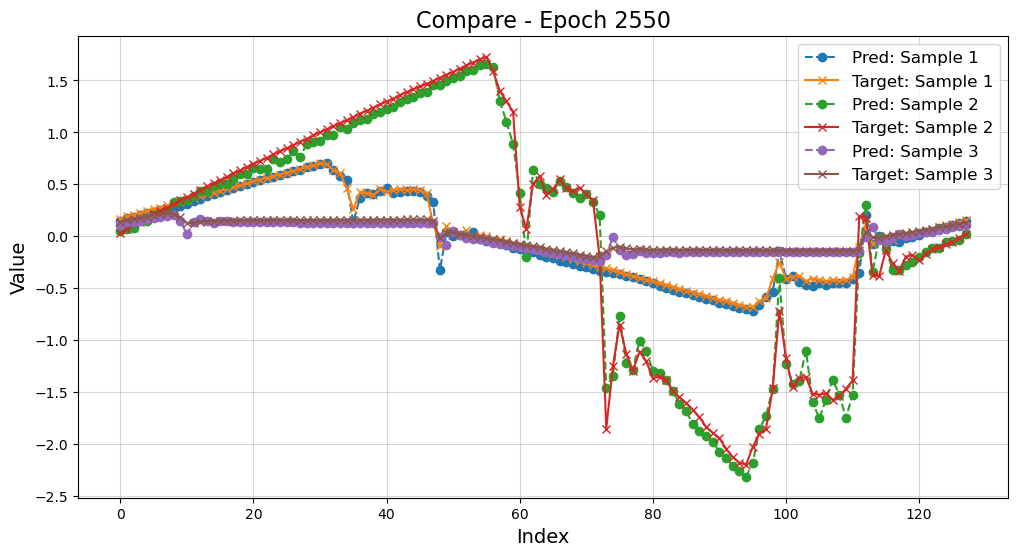

Epoch 2551, Train Loss: 0.005849, Validation Loss: 0.006172
Epoch 2552, Train Loss: 0.005832, Validation Loss: 0.006305
Epoch 2553, Train Loss: 0.005986, Validation Loss: 0.006764
Epoch 2554, Train Loss: 0.005962, Validation Loss: 0.006113
Epoch 2555, Train Loss: 0.006004, Validation Loss: 0.006357
Epoch 2556, Train Loss: 0.005955, Validation Loss: 0.006216
Epoch 2557, Train Loss: 0.005870, Validation Loss: 0.006151
Epoch 2558, Train Loss: 0.005829, Validation Loss: 0.006107
Epoch 2559, Train Loss: 0.006065, Validation Loss: 0.006111
Epoch 2560, Train Loss: 0.006030, Validation Loss: 0.006188
Epoch 2561, Train Loss: 0.005966, Validation Loss: 0.006061
Epoch 2562, Train Loss: 0.005951, Validation Loss: 0.006276
Epoch 2563, Train Loss: 0.005898, Validation Loss: 0.006123
Epoch 2564, Train Loss: 0.005915, Validation Loss: 0.006347
Epoch 2565, Train Loss: 0.006236, Validation Loss: 0.006238
Epoch 2566, Train Loss: 0.005992, Validation Loss: 0.006130
Epoch 2567, Train Loss: 0.005909, Valida

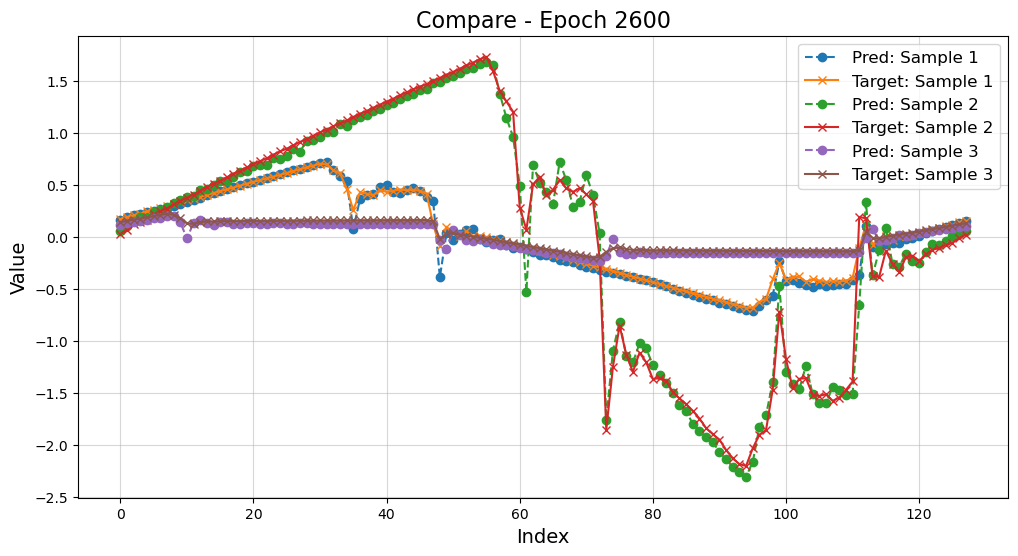

Epoch 2601, Train Loss: 0.006104, Validation Loss: 0.006078
Epoch 2602, Train Loss: 0.006074, Validation Loss: 0.006710
Epoch 2603, Train Loss: 0.005940, Validation Loss: 0.006140
Epoch 2604, Train Loss: 0.005839, Validation Loss: 0.006066
Epoch 2605, Train Loss: 0.006023, Validation Loss: 0.006345
Epoch 2606, Train Loss: 0.006017, Validation Loss: 0.006132
Epoch 2607, Train Loss: 0.005919, Validation Loss: 0.006193
Epoch 2608, Train Loss: 0.005923, Validation Loss: 0.006338
Epoch 2609, Train Loss: 0.005968, Validation Loss: 0.008872
Epoch 2610, Train Loss: 0.005988, Validation Loss: 0.006093
Epoch 2611, Train Loss: 0.005889, Validation Loss: 0.006222
Epoch 2612, Train Loss: 0.005911, Validation Loss: 0.006265
Epoch 2613, Train Loss: 0.005819, Validation Loss: 0.006064
Epoch 2614, Train Loss: 0.006097, Validation Loss: 0.006377
Epoch 2615, Train Loss: 0.005956, Validation Loss: 0.006499
Epoch 2616, Train Loss: 0.006080, Validation Loss: 0.006164
Epoch 2617, Train Loss: 0.005951, Valida

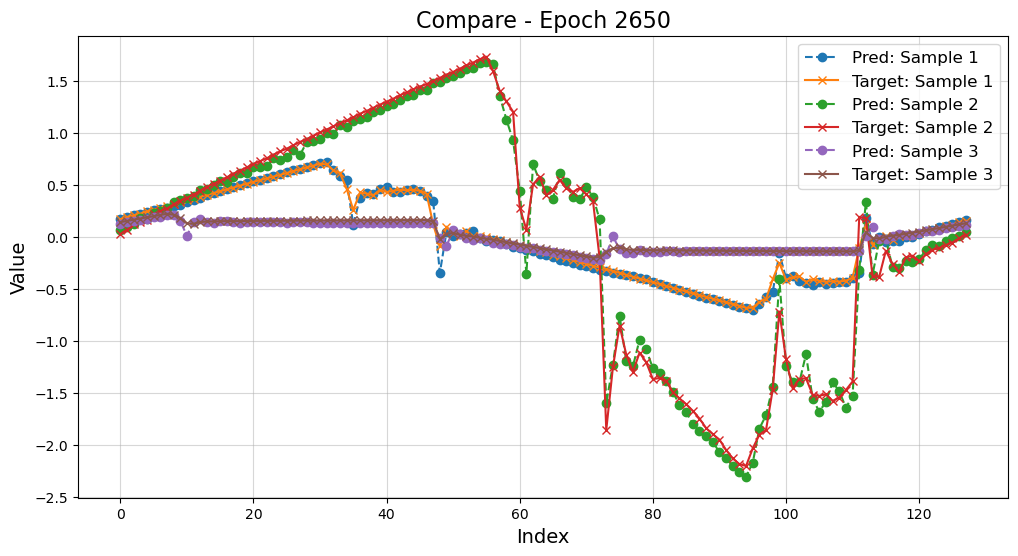

Epoch 2651, Train Loss: 0.005890, Validation Loss: 0.005988
Epoch 2652, Train Loss: 0.006003, Validation Loss: 0.007330
Epoch 2653, Train Loss: 0.005910, Validation Loss: 0.006067
Epoch 2654, Train Loss: 0.005895, Validation Loss: 0.006397
Epoch 2655, Train Loss: 0.006009, Validation Loss: 0.006461
Epoch 2656, Train Loss: 0.006025, Validation Loss: 0.006666
Epoch 2657, Train Loss: 0.006196, Validation Loss: 0.006132
Epoch 2658, Train Loss: 0.005832, Validation Loss: 0.006281
Epoch 2659, Train Loss: 0.005846, Validation Loss: 0.006513
Epoch 2660, Train Loss: 0.005920, Validation Loss: 0.006384
Epoch 2661, Train Loss: 0.005826, Validation Loss: 0.006003
Epoch 2662, Train Loss: 0.005866, Validation Loss: 0.007168
Epoch 2663, Train Loss: 0.006064, Validation Loss: 0.006107
Epoch 2664, Train Loss: 0.005894, Validation Loss: 0.006563
Epoch 2665, Train Loss: 0.005860, Validation Loss: 0.006121
Epoch 2666, Train Loss: 0.005790, Validation Loss: 0.005985
Epoch 2667, Train Loss: 0.005888, Valida

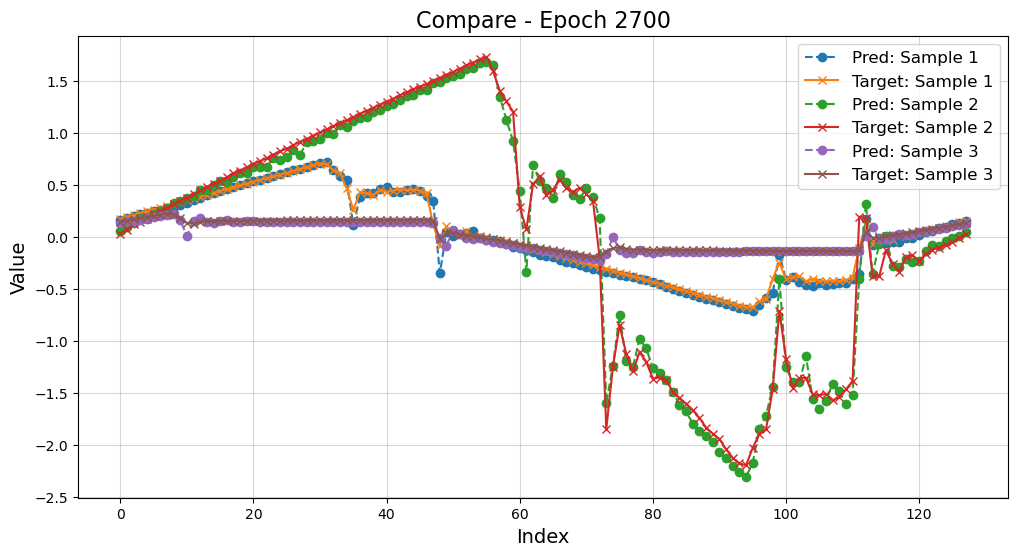

Epoch 2701, Train Loss: 0.005796, Validation Loss: 0.006110
Epoch 2702, Train Loss: 0.005896, Validation Loss: 0.006072
Epoch 2703, Train Loss: 0.006012, Validation Loss: 0.006739
Epoch 2704, Train Loss: 0.005944, Validation Loss: 0.006122
Epoch 2705, Train Loss: 0.005767, Validation Loss: 0.006138
Epoch 2706, Train Loss: 0.005914, Validation Loss: 0.006667
Epoch 2707, Train Loss: 0.005791, Validation Loss: 0.006050
Epoch 2708, Train Loss: 0.005747, Validation Loss: 0.006057
Epoch 2709, Train Loss: 0.005795, Validation Loss: 0.006004
Epoch 2710, Train Loss: 0.005861, Validation Loss: 0.006135
Epoch 2711, Train Loss: 0.005924, Validation Loss: 0.008523
Epoch 2712, Train Loss: 0.006008, Validation Loss: 0.006229
Epoch 2713, Train Loss: 0.005702, Validation Loss: 0.006034
Epoch 2714, Train Loss: 0.005807, Validation Loss: 0.006387
Epoch 2715, Train Loss: 0.005842, Validation Loss: 0.006021
Epoch 2716, Train Loss: 0.005825, Validation Loss: 0.006090
Epoch 2717, Train Loss: 0.006036, Valida

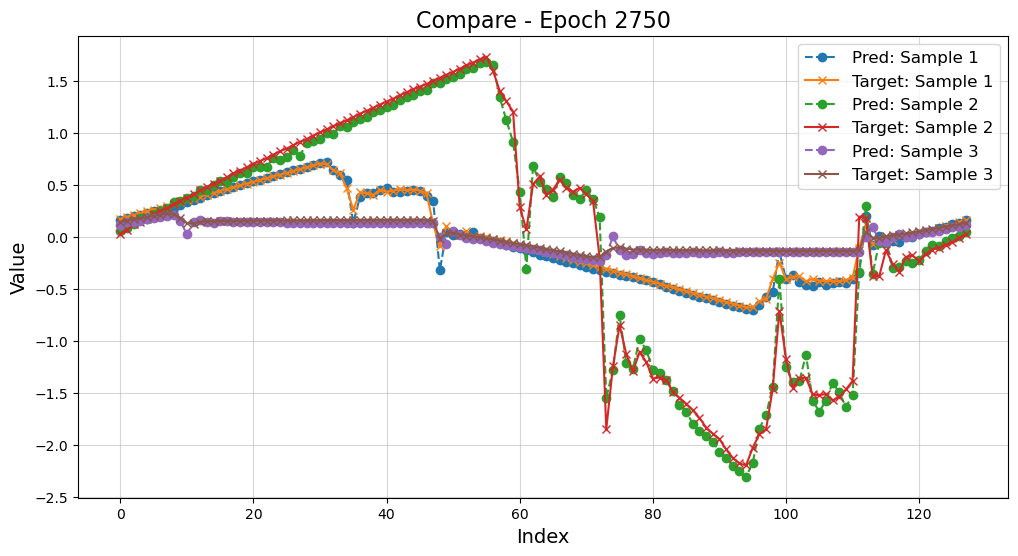

Epoch 2751, Train Loss: 0.005753, Validation Loss: 0.006099
Epoch 2752, Train Loss: 0.005749, Validation Loss: 0.006026
Epoch 2753, Train Loss: 0.005904, Validation Loss: 0.006133
Epoch 2754, Train Loss: 0.005861, Validation Loss: 0.005985
Epoch 2755, Train Loss: 0.005818, Validation Loss: 0.006185
Epoch 2756, Train Loss: 0.005927, Validation Loss: 0.006109
Epoch 2757, Train Loss: 0.005769, Validation Loss: 0.006086
Epoch 2758, Train Loss: 0.005806, Validation Loss: 0.006146
Epoch 2759, Train Loss: 0.005830, Validation Loss: 0.006171
Epoch 2760, Train Loss: 0.005890, Validation Loss: 0.006286
Epoch 2761, Train Loss: 0.005817, Validation Loss: 0.005926
Epoch 2762, Train Loss: 0.006010, Validation Loss: 0.006067
Epoch 2763, Train Loss: 0.005733, Validation Loss: 0.006451
Epoch 2764, Train Loss: 0.006006, Validation Loss: 0.005953
Epoch 2765, Train Loss: 0.005821, Validation Loss: 0.006304
Epoch 2766, Train Loss: 0.005851, Validation Loss: 0.006568
Epoch 2767, Train Loss: 0.005827, Valida

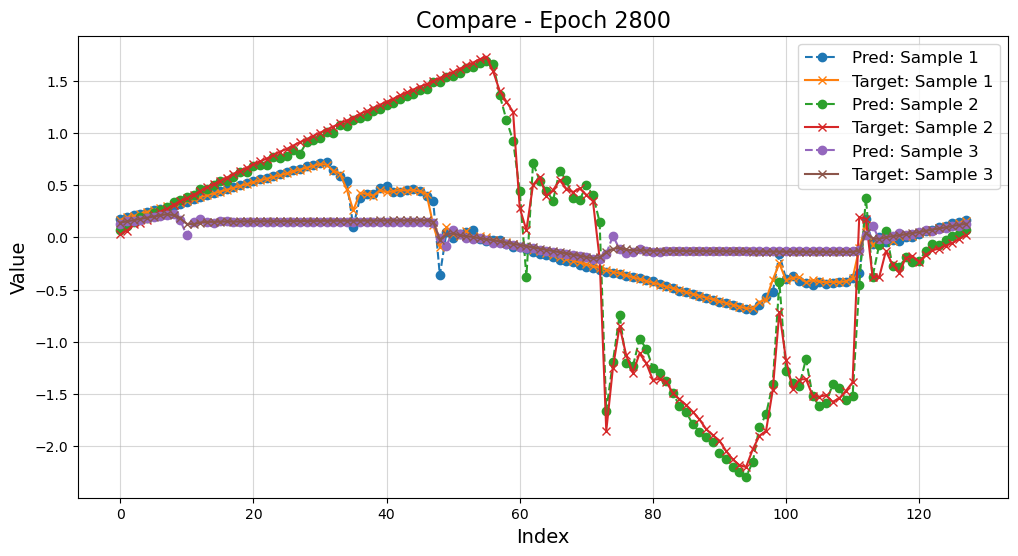

Epoch 2801, Train Loss: 0.005693, Validation Loss: 0.006183
Epoch 2802, Train Loss: 0.005837, Validation Loss: 0.006297
Epoch 2803, Train Loss: 0.005833, Validation Loss: 0.005913
Saving model at epoch 2803 with validation loss 0.005913...
Epoch 2804, Train Loss: 0.005624, Validation Loss: 0.005900
Saving model at epoch 2804 with validation loss 0.005900...
Epoch 2805, Train Loss: 0.005936, Validation Loss: 0.006429
Epoch 2806, Train Loss: 0.005883, Validation Loss: 0.006129
Epoch 2807, Train Loss: 0.005764, Validation Loss: 0.005999
Epoch 2808, Train Loss: 0.005939, Validation Loss: 0.005926
Epoch 2809, Train Loss: 0.005671, Validation Loss: 0.005957
Epoch 2810, Train Loss: 0.005768, Validation Loss: 0.006154
Epoch 2811, Train Loss: 0.005810, Validation Loss: 0.006204
Epoch 2812, Train Loss: 0.005809, Validation Loss: 0.006330
Epoch 2813, Train Loss: 0.005827, Validation Loss: 0.006243
Epoch 2814, Train Loss: 0.005735, Validation Loss: 0.006343
Epoch 2815, Train Loss: 0.005887, Valida

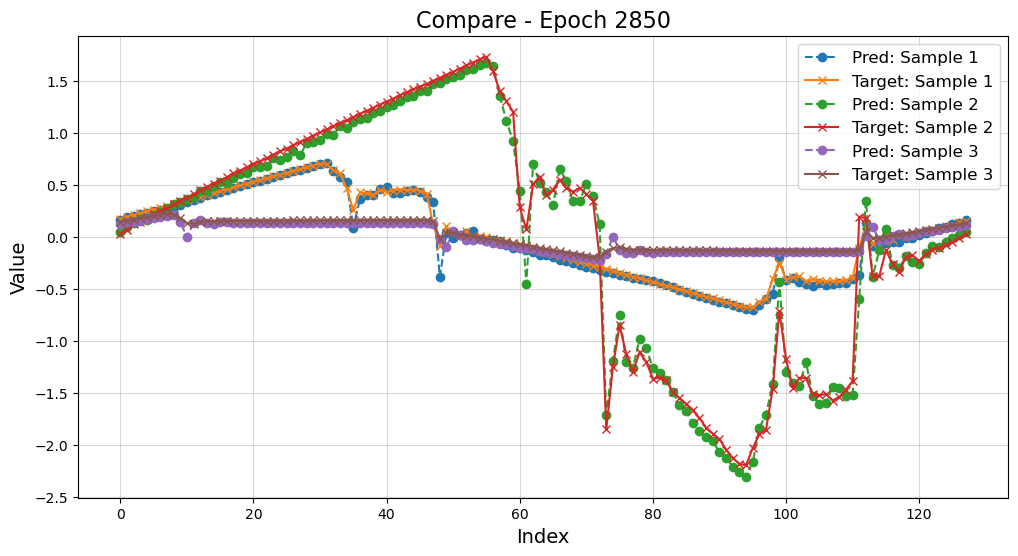

Epoch 2851, Train Loss: 0.005844, Validation Loss: 0.006670
Epoch 2852, Train Loss: 0.005811, Validation Loss: 0.005980
Epoch 2853, Train Loss: 0.005654, Validation Loss: 0.006405
Epoch 2854, Train Loss: 0.005730, Validation Loss: 0.006015
Epoch 2855, Train Loss: 0.005982, Validation Loss: 0.007017
Epoch 2856, Train Loss: 0.005898, Validation Loss: 0.006106
Epoch 2857, Train Loss: 0.005656, Validation Loss: 0.005963
Epoch 2858, Train Loss: 0.005767, Validation Loss: 0.006445
Epoch 2859, Train Loss: 0.005966, Validation Loss: 0.006293
Epoch 2860, Train Loss: 0.005734, Validation Loss: 0.006217
Epoch 2861, Train Loss: 0.005847, Validation Loss: 0.006119
Epoch 2862, Train Loss: 0.005881, Validation Loss: 0.007389
Epoch 2863, Train Loss: 0.006013, Validation Loss: 0.005953
Epoch 2864, Train Loss: 0.005767, Validation Loss: 0.005873
Saving model at epoch 2864 with validation loss 0.005873...
Epoch 2865, Train Loss: 0.005731, Validation Loss: 0.006167
Epoch 2866, Train Loss: 0.005683, Valida

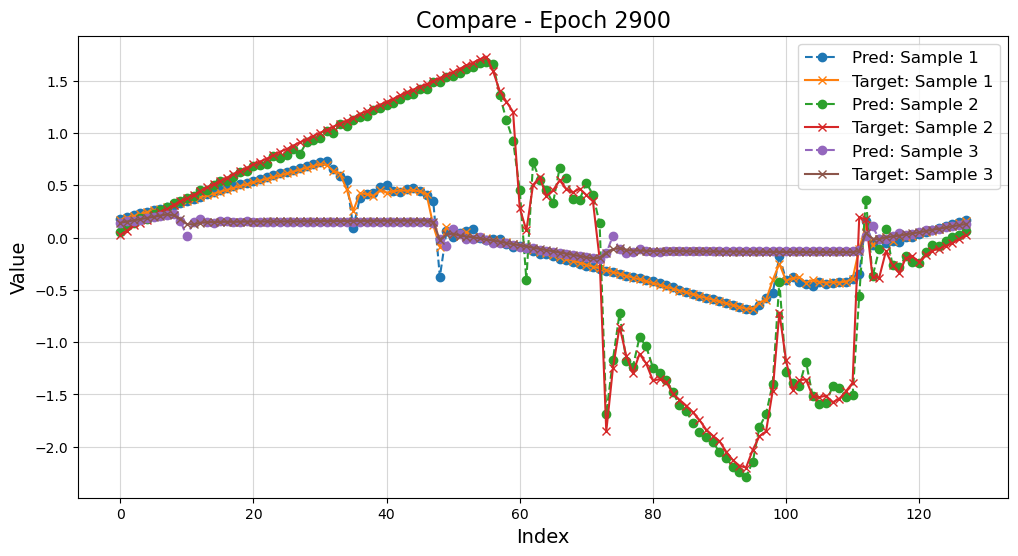

Epoch 2901, Train Loss: 0.005771, Validation Loss: 0.005978
Epoch 2902, Train Loss: 0.005721, Validation Loss: 0.005985
Epoch 2903, Train Loss: 0.005777, Validation Loss: 0.006200
Epoch 2904, Train Loss: 0.005893, Validation Loss: 0.005853
Saving model at epoch 2904 with validation loss 0.005853...
Epoch 2905, Train Loss: 0.005725, Validation Loss: 0.006006
Epoch 2906, Train Loss: 0.005709, Validation Loss: 0.006062
Epoch 2907, Train Loss: 0.005710, Validation Loss: 0.006095
Epoch 2908, Train Loss: 0.005906, Validation Loss: 0.006068
Epoch 2909, Train Loss: 0.005732, Validation Loss: 0.005882
Epoch 2910, Train Loss: 0.005861, Validation Loss: 0.006455
Epoch 2911, Train Loss: 0.005785, Validation Loss: 0.005884
Epoch 2912, Train Loss: 0.005787, Validation Loss: 0.005920
Epoch 2913, Train Loss: 0.005692, Validation Loss: 0.006037
Epoch 2914, Train Loss: 0.005786, Validation Loss: 0.006768
Epoch 2915, Train Loss: 0.005951, Validation Loss: 0.006043
Epoch 2916, Train Loss: 0.005792, Valida

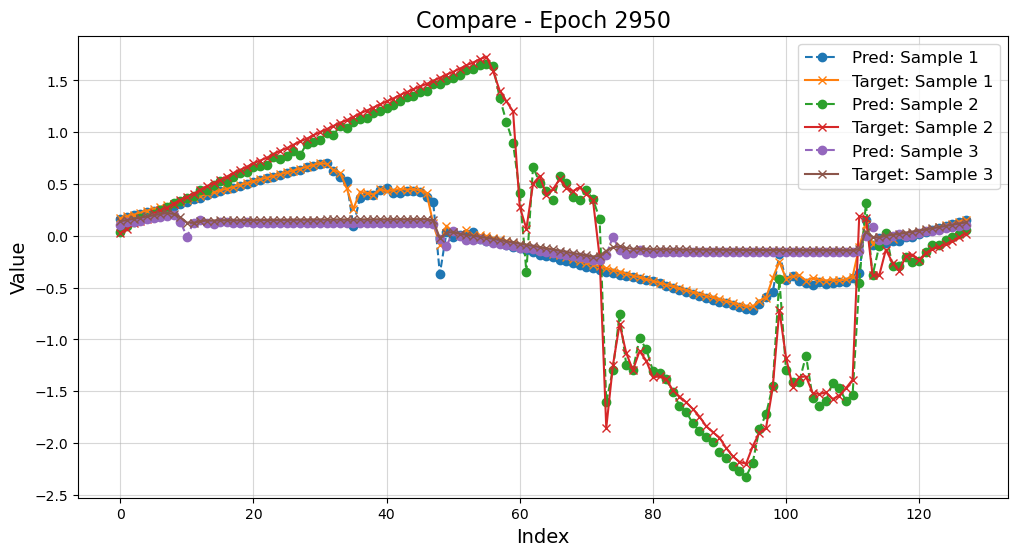

Epoch 2951, Train Loss: 0.005916, Validation Loss: 0.006016
Epoch 2952, Train Loss: 0.005839, Validation Loss: 0.006258
Epoch 2953, Train Loss: 0.006020, Validation Loss: 0.006559
Epoch 2954, Train Loss: 0.005698, Validation Loss: 0.005902
Epoch 2955, Train Loss: 0.005709, Validation Loss: 0.006051
Epoch 2956, Train Loss: 0.005936, Validation Loss: 0.006022
Epoch 2957, Train Loss: 0.005685, Validation Loss: 0.006117
Epoch 2958, Train Loss: 0.005800, Validation Loss: 0.006340
Epoch 2959, Train Loss: 0.005745, Validation Loss: 0.005882
Epoch 2960, Train Loss: 0.005659, Validation Loss: 0.006268
Epoch 2961, Train Loss: 0.005849, Validation Loss: 0.006134
Epoch 2962, Train Loss: 0.005868, Validation Loss: 0.005919
Epoch 2963, Train Loss: 0.005636, Validation Loss: 0.006060
Epoch 2964, Train Loss: 0.005633, Validation Loss: 0.006723
Epoch 2965, Train Loss: 0.005932, Validation Loss: 0.006961
Epoch 2966, Train Loss: 0.006013, Validation Loss: 0.006470
Epoch 2967, Train Loss: 0.005744, Valida

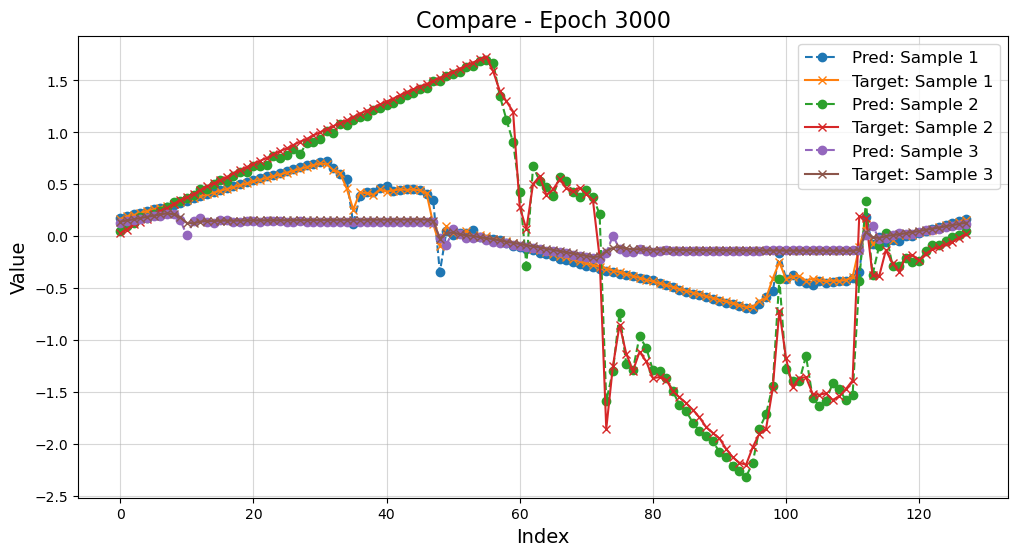

Training complete. Best model saved at ./Model/Material B.pt.


In [40]:
if __name__ == "__main__":

    data_B, data_F, data_T, data_H, data_Pcv = load_dataset(material)
    norm = normsDict[material]

    train_loader, valid_loader = get_dataloader(data_B, data_F, data_T, data_H,
                                                data_Pcv, norm)

    train_model(train_loader, valid_loader)